# Исследование данных для HR-анлитики

**Цель исследования** - помочь бизнесу оптимизировать управление персоналом.

**Задачи:**
1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника.
2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**План исследования:**

1. Задача 1:
    1. Изучить данные.
    2. Предаброботка данных.
    3. Исследовательский анализ данных.
    4. Корреляционный анализ.
    5. Обучение модели.
    6. Вывод.

2. Задача 2:
    1. Изучить данные.
    2. Предаброботка данных.
    3. Исследовательский анализ данных.
    4. Корреляционный анализ.
    5. Обучение модели.
    6. Вывод.

3. Общий вывод

**Согласно документации к данным.**

Для этой задачи заказчик предоставил данные с признаками:
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

**Задача 1**
- В датасете `train_job_satisfaction_rate.csv` находится тренировочная выборка.
- В датасете `test_features` находится входные признаки тестовой выборки.
- В датасете `test_target_job_satisfaction_rate.csv` находится целевой признак тестовой выборки.

**Задача 2**
- В датасете `train_quit.csv` нахоидтся тренировочная выборка
- В датасете `test_features.csv` находится входные признаки тестовой выборки
- В датасете `test_target_quit.csv` находится целевой признак тестовой выборки

## Задача 1
### Изучение данных
#### Импорт библиотек

In [1]:
import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт scipy для проверки гипотез
from scipy import stats as st

# импортируем для машинного обучения
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder)
from sklearn.impute import SimpleImputer

# Импортируем метрики для оценки качества модели
from sklearn.metrics import roc_auc_score, make_scorer
# Загружаем классы для работы с пайплайном
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Импортируем сторонние библиотеки
import phik
from phik.report import plot_correlation_matrix

#### Функции

In [2]:
def custom_metric(y_true, y_pred):
    '''
    Фунция для собсвенной метрики  SMAPE
    симметричное среднее абсолютное процентное отклонение

    '''

    smape_metric = abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred))/2)
    metric = 100/len(y_true) * smape_metric.sum()
    return metric

In [3]:
def barplot(data, xlabel, title):
    '''
    Функция строит барплот на вход
    принимает сгрупированные данные,
    название оси Х и название графика
    
    '''

    data.plot.bar()
    plt.grid()
    plt.xticks(rotation=45)
    plt.ylabel('Количество сотрудников')
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

#### Константы

In [4]:
# Задаем константу для деления датасета на одинаковые выборки
RANDOM_STATE = 42

#### Загрузка данных и их изучение

In [5]:
# Для игнорирования ошибок
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

In [6]:
pth1 = r"C:\Users\stepa\Downloads\train_job_satisfaction_rate.csv"
pth2 = r"C:\Users\stepa\Downloads\test_features.csv"
pth3 = r"C:\Users\stepa\Downloads\test_target_job_satisfaction_rate.csv"

In [7]:
if os.path.exists(pth1):
    satisfaction_rate = pd.read_csv(pth1)
else:
    print('Ошибка')

In [8]:
if os.path.exists(pth2):
    test_features = pd.read_csv(pth2)
else:
    print('Ошибка')

In [9]:
if os.path.exists(pth3):
    test_target_rate = pd.read_csv(pth3)
else:
    print('Ошибка')

Выведем первые 5 строк всех таблиц

In [10]:
satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [11]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [12]:
test_target_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Посмотрим на общую информацию о данных в таблицах

In [13]:
satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [14]:
satisfaction_rate.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


Рассмотрим полученную информацию подробнее.

Всего в таблице 10 столбцов, тип данных - `int`(4), `object`(5), `float`(1).
Количестов значений в столбцах `level` и `dept` разное, а значит есть пропуски. Название столбцов соотвествует стилю. Исходя из данных аномальных значений нет

In [15]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [16]:
test_features.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


Рассмотрим полученную информацию подробнее.

Всего в таблице 9 столбцов, тип данных - `int`(4), `object`(5).
Количестов значений в столбцах `level` и `dept` разное, а значит есть пропущенные значения. Название столбцов соотвествует стилю. Исходя из данных аномальных значений нет

In [17]:
test_target_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Рассмотрим полученную информацию подробнее.

Всего в таблице 2 столбца, тип данных - `int`(1), `float`(1).
Количестов значений в столбцах одинаковое, а значит пропусков нет. Название столбцов соотвествует стилю.

#### Вывод.

Каждая сторка таблиц содержит информацию о сотрудниках. Есть несколько проблем:

1. В датасетах `test_features` и `satisfaction_rate` обнаружены пропуски их мы заполним в пайплайне.
2. Необходимо сделать проверку на явные и неявные дубликаты.

### Предобработка данных.
####  Работа с явными дубликатами.

Сделаем проверку на явные дубликаты во всех таблицах.

In [18]:
satisfaction_rate.duplicated().sum()  # Проверяем количество явных дубликатов

0

In [19]:
test_features.duplicated().sum()  # Проверяем количество явных дубликатов

0

In [20]:
test_target_rate.duplicated().sum()  # Проверяем количество явных дубликатов

0

Во всех таблицах явных дубликатов не обнаружено.

#### Работа с неявными дубликатами.

Предположим, что в таблице `satisfaction_rate` в столбцах, имеющие строковый тип данных, одно и тоже значение переменной может быть написано по-разному, то есть проверим столбцы:

- `dept`;
- `level`;
- `workload`;
- `last_year_promo`;
- `last_year_violations`.

In [21]:
# Считаем количество уникальных значений
satisfaction_rate_dept = satisfaction_rate['dept'].value_counts()
satisfaction_rate_dept

dept
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: count, dtype: int64

In [22]:
# Считаем количество уникальных значений
satisfaction_rate['level'].value_counts()

level
junior    1894
middle    1744
sinior     358
Name: count, dtype: int64

Можно заметить, что в `satisfaction_rate` в столбце `level` название должности написано неправильно, а именно заменим `sinior` на `senior`.

In [23]:
satisfaction_rate['level'] = satisfaction_rate['level'].replace(
    'sinior', 'senior')

Проверим результат работы.

In [24]:
# Считаем количество уникальных значений
satisfaction_rate_level = satisfaction_rate['level'].value_counts()
satisfaction_rate_level

level
junior    1894
middle    1744
senior     358
Name: count, dtype: int64

In [25]:
# Считаем количество уникальных значений
satisfaction_rate_workload = satisfaction_rate['workload'].value_counts()
satisfaction_rate_workload

workload
medium    2066
low       1200
high       734
Name: count, dtype: int64

In [26]:
# Считаем количество уникальных значений
satisfaction_rate_promo = satisfaction_rate['last_year_promo'].value_counts()
satisfaction_rate_promo

last_year_promo
no     3880
yes     120
Name: count, dtype: int64

In [27]:
# Считаем количество уникальных значений
satisfaction_rate_viol = satisfaction_rate['last_year_violations'].value_counts()
satisfaction_rate_viol

last_year_violations
no     3441
yes     559
Name: count, dtype: int64

Неявных дубликатов в датасете `satisfaction_rate` не были обнаружены.

Сделаем такую же проверку для датафрейма `test_features`.

In [28]:
test_features['dept'].value_counts()  # Считаем количество уникальных значений

dept
sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: count, dtype: int64

Необходимо заполнить пустое значение, заполним его модой.

In [29]:
test_features['dept'] = test_features['dept'].replace(
    ' ', test_features['dept'].mode()[0])

Сделаем проверку.

In [30]:
test_features[test_features['dept'] == ' ']  # Выводим пустые значение в dept

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


In [31]:
# Считаем количество уникальных значений
test_features_dept = test_features['dept'].value_counts()
test_features_dept

dept
sales         764
technology    455
marketing     279
purchasing    273
hr            227
Name: count, dtype: int64

In [32]:
test_features['level'].value_counts()  # Считаем количество уникальных значений

level
junior    974
middle    854
sinior    171
Name: count, dtype: int64

Можно заметить, что в `test_features` в столбце `level` название должности написано неправильно, а именно заменим `sinior` на `senior`.

In [33]:
test_features['level'] = test_features['level'].replace('sinior', 'senior')

Сделаем проверку

In [34]:
# Считаем количество уникальных значений
test_features_level = test_features['level'].value_counts()
test_features_level

level
junior    974
middle    854
senior    171
Name: count, dtype: int64

In [35]:
# Считаем количество уникальных значений
test_features['workload'].value_counts()

workload
medium    1043
low        593
high       363
             1
Name: count, dtype: int64

Заполним пустой значение в `workload`. Посмотрим как распределена загруженность сотрудников в зависимости от должности

In [36]:
test_features.groupby(['workload', 'dept'])['id'].count()

workload  dept      
          marketing       1
high      hr             41
          marketing      50
          purchasing     52
          sales         139
          technology     81
low       hr             63
          marketing      93
          purchasing     72
          sales         247
          technology    118
medium    hr            123
          marketing     135
          purchasing    149
          sales         378
          technology    256
Name: id, dtype: int64

In [37]:
# Смотрим на сотрудника с пустым значением
test_features[test_features['workload'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


Исходя из результатов, пустое значение следует заполнить `medium`, так как должность `marketing` встречается здесь чаще, чем на других уровнях загруженности. И проверим результат работы.

In [38]:
test_features['workload'] = test_features['workload'].replace(' ', 'medium')

In [39]:
test_features[test_features['workload'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


In [40]:
# Считаем количество уникальных значений
test_features_workload = test_features['workload'].value_counts()
test_features_workload

workload
medium    1044
low        593
high       363
Name: count, dtype: int64

In [41]:
# Считаем количество уникальных значений
test_features_promo = test_features['last_year_promo'].value_counts()
test_features_promo

last_year_promo
no     1937
yes      63
Name: count, dtype: int64

In [42]:
# Считаем количество уникальных значений
test_features_viol = test_features['last_year_violations'].value_counts()
test_features_viol

last_year_violations
no     1738
yes     262
Name: count, dtype: int64

В датафрейме неявных дубликатов необнаружено.

#### Вывод

На данном этапе были сделаны следующие действия:

1. Сделали проверку на явные дубликаты - **не обнаружены**.
2. Сделали проверку на неявные дубликаты - **не обнаружены**.
3. Исправили ошибку в название должности в столбце `level` в датафреймах `satisfaction_rate`и `test_features` c `sinior` на `senior`.
4. В датафрейме `test_features` в столбцах `dept` и `workload` были обнаружены пустые значения и заполнили их модой. Столбец `workload` заполнялся модой в зависимости от загружености по должности.
5. Пропуски будут заполнены во время подготовки данных к МО в пайплайне.

### Исследовательский анализ данных.

Исследуем данные в датафрейме `satisfaction_rate`:
- Выясним процентное соотношение отделов, уровня должности, уровня загруженности, было ли повышение за последний год и нарушал ли сотрудник трудовой договор за последний год.
- Изучим количественные переменные:  длительность работы в компании, оценка качества работы сотрудника, зарплата и уровень удовлетворённости сотрудника.

Исследуем данные в датафрейме `test_features`:
- Выясним процентное соотношение отделов, уровня должности, уровня загруженности, было ли повышение за последний год и нарушал ли сотрудник трудовой договор за последний год.
- Изучим количественные переменные:  длительность работы в компании, оценка качества работы сотрудника и зарплата.

Исследуем количественный столбец в датафрейме `test_target_rate`.

#### Исследуем датафрейм `satisfaction_rate`.

Начнем с анализа таблицы `satisfaction_rate` и построим круговые диаграммы.

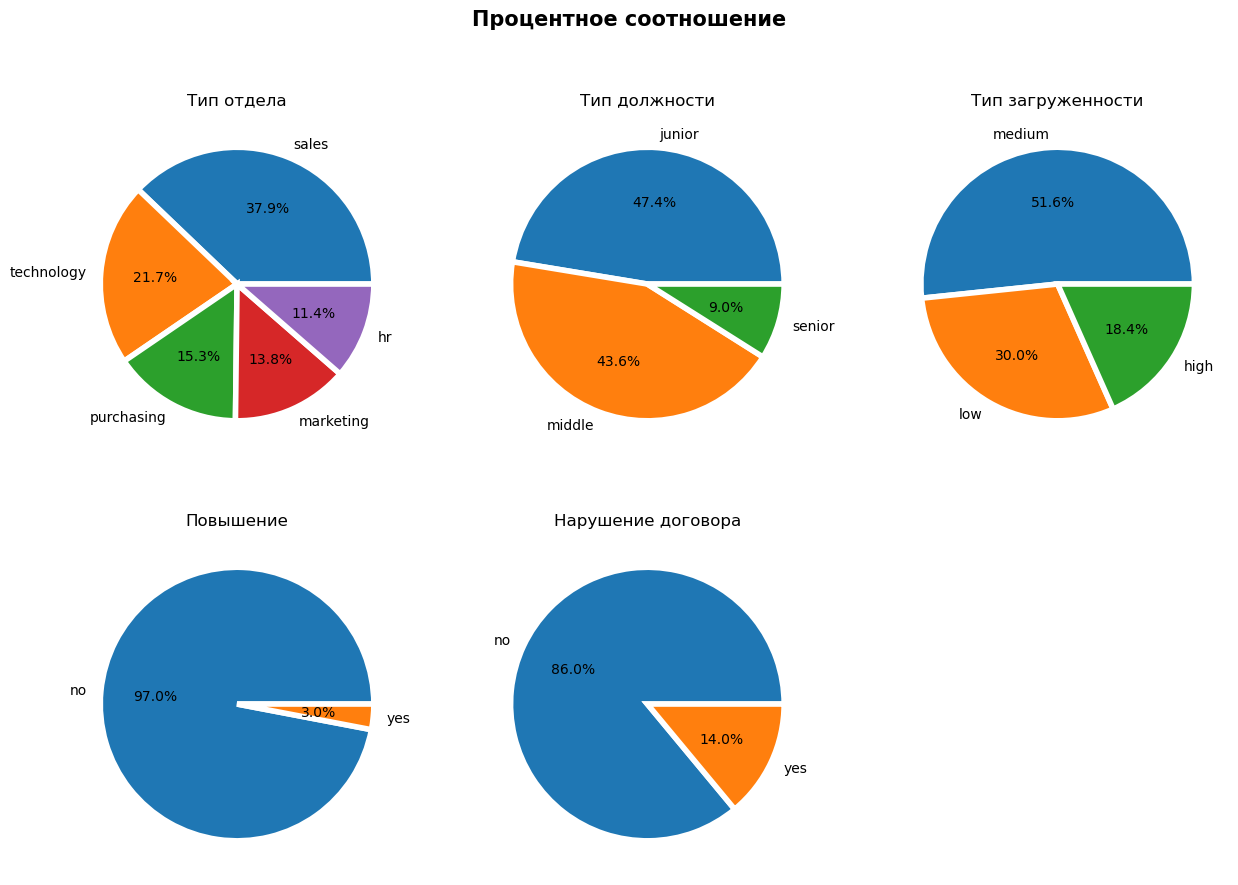

In [43]:
plt.figure(figsize=(15, 10))

plt.suptitle('Процентное соотношение', fontsize=15, fontweight='bold')

plt.subplot(2, 3, 1)
plt.pie(satisfaction_rate_dept.values,
        labels=satisfaction_rate_dept.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Тип отдела')

plt.subplot(2, 3, 2)
plt.pie(satisfaction_rate_level.values,
        labels=satisfaction_rate_level.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Тип должности')

plt.subplot(2, 3, 3)
plt.pie(satisfaction_rate_workload.values,
        labels=satisfaction_rate_workload.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Тип загруженности')

plt.subplot(2, 3, 4)
plt.pie(satisfaction_rate_promo.values,
        labels=satisfaction_rate_promo.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Повышение')

plt.subplot(2, 3, 5)
plt.pie(satisfaction_rate_viol.values,
        labels=satisfaction_rate_viol.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Нарушение договора')
plt.show()

Можно сказать следующие:

- Больше людей работают в отделе `sales` - 37.9%. Меньше всего сотрудников в отделе `hr` - 11.4%
- Больше всего сотрудников уровня `junior` - 47.4%, но также много сотрудников уровня `middle` - 43.6%, меньше всего `senior` - 9%
- Большая часть сотрудников имеет среднюю нагржуеность - 51.6%
- Всего у 3% сотрудников было повышение за год.
- 14% сотрудников нарушали трудовой договор за год.

Теперь изучим количественные перменные и сначала построим диаграмму размаха.

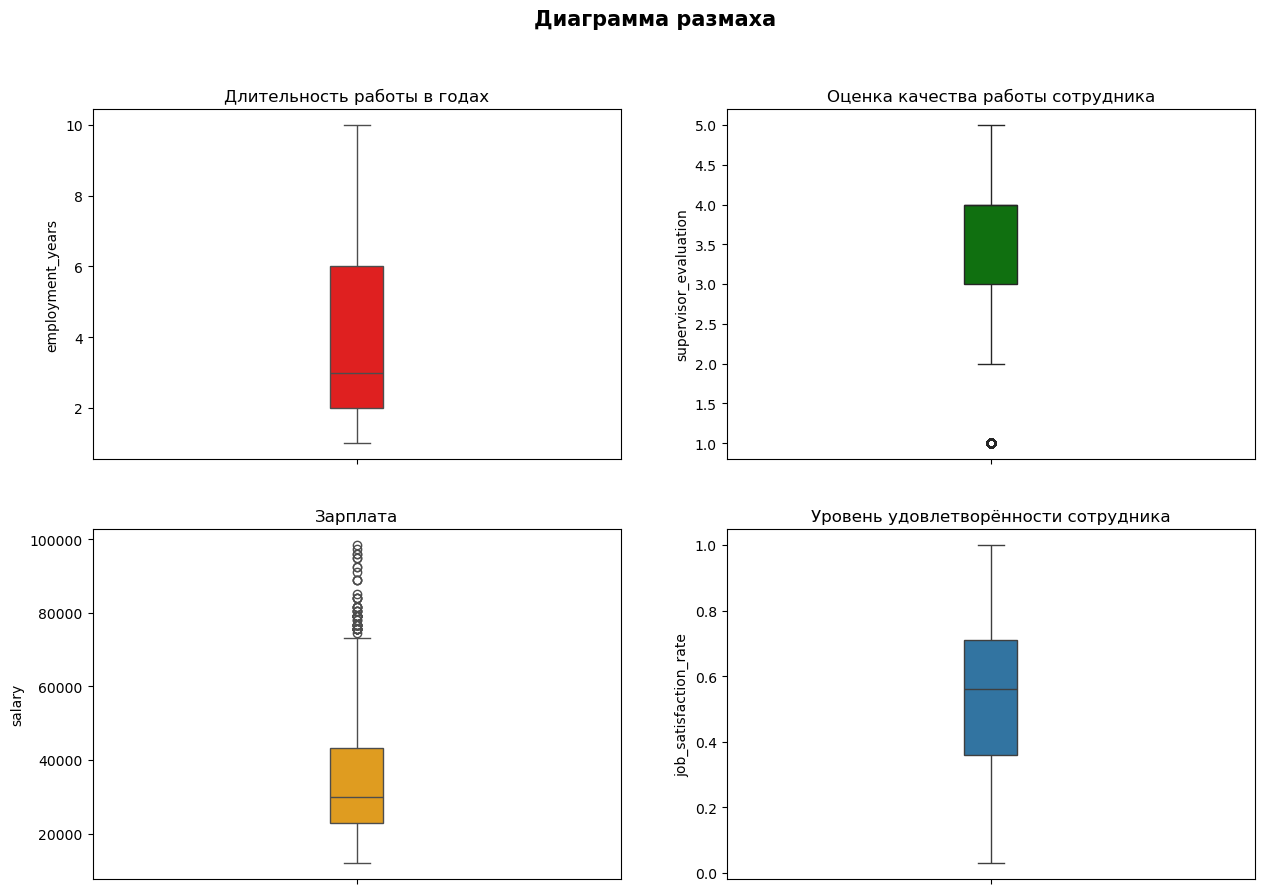

In [44]:
plt.figure(figsize=(15, 10))

plt.suptitle('Диаграмма размаха', fontsize=15, fontweight='bold')

plt.subplot(2, 2, 1)
sns.boxplot(y=satisfaction_rate['employment_years'], width=.1, color='red')
plt.title('Длительность работы в годах')

plt.subplot(2, 2, 2)
sns.boxplot(
    y=satisfaction_rate['supervisor_evaluation'], width=.1, color='green')
plt.title('Оценка качества работы сотрудника')

plt.subplot(2, 2, 3)
sns.boxplot(y=satisfaction_rate['salary'], width=.1, color='orange')
plt.title('Зарплата')

plt.subplot(2, 2, 4)
sns.boxplot(y=satisfaction_rate['job_satisfaction_rate'], width=.1)
plt.title('Уровень удовлетворённости сотрудника')
plt.show()

Из графиков видно, что в столбцах `supervisor_evaluation` и `salary` есть выбросы, но сами эти значения не будут аномальными, так как на графике оценка качества работы, выбросами являются маленькие оценки, что в принципе возможно, так как руководитель просто очень низко оценил работу сотрудника. А на графике зарплата, значения тоже не являются аномальными, так как просто есть люди, у которых очень высокая зарплата по компании, но она находится в разумных пределах.

Теперь построим гистограммы по количественным переменным.

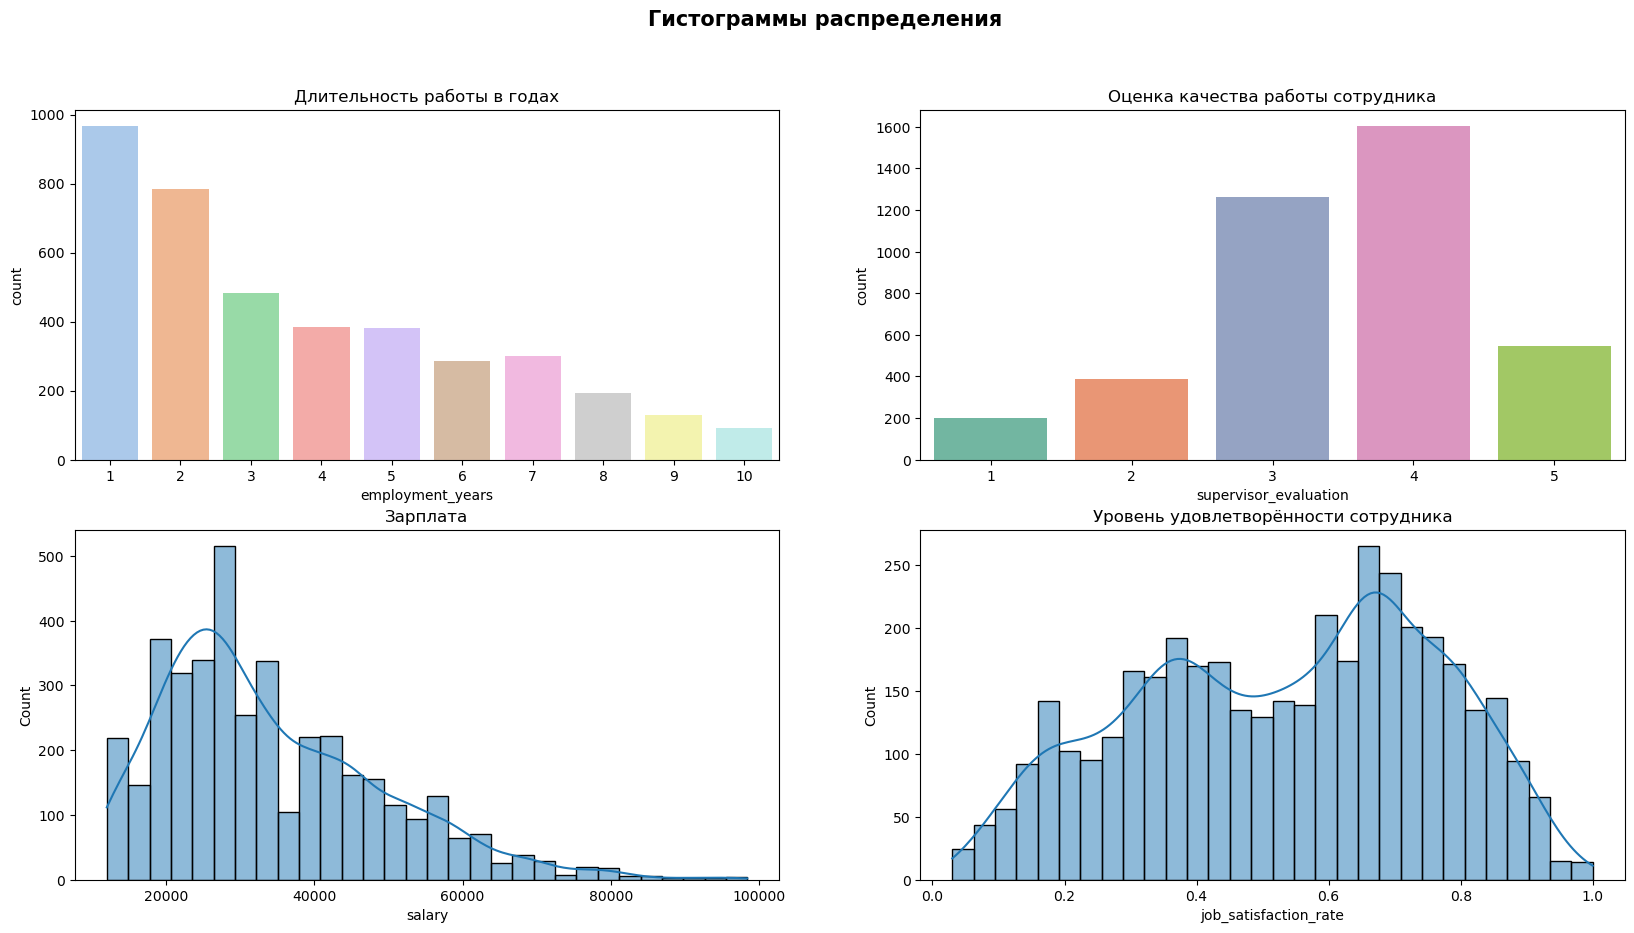

In [45]:
plt.figure(figsize=(20, 10))

plt.suptitle('Гистограммы распределения', fontsize=15, fontweight='bold')

plt.subplot(2, 2, 1)
sns.countplot(x='employment_years', data=satisfaction_rate, palette='pastel')
plt.title('Длительность работы в годах')

plt.subplot(2, 2, 2)
sns.countplot(x='supervisor_evaluation', data=satisfaction_rate, palette='Set2')
plt.title('Оценка качества работы сотрудника')

plt.subplot(2, 2, 3)
sns.histplot(satisfaction_rate['salary'], kde=True, bins=30)
plt.title('Зарплата')

plt.subplot(2, 2, 4)
sns.histplot(satisfaction_rate['job_satisfaction_rate'], kde=True, bins=30)
plt.title('Уровень удовлетворённости сотрудника')
plt.show()

Количественные признаки распределены ненормально, график длительности работы похож на асеммитричное распределение, график уровня удовлетворенности сотрудника похож на мультимодальное распределение, график зарплаты асеммитричное распределение смешенное вправо, а график качества работы тож похож на асеммитричное распределение.

#### Исследуем датафрейм `test_features`.

Проведем такой же анализ для датафрейма `test_features` и начнем с круговых диаграмм.

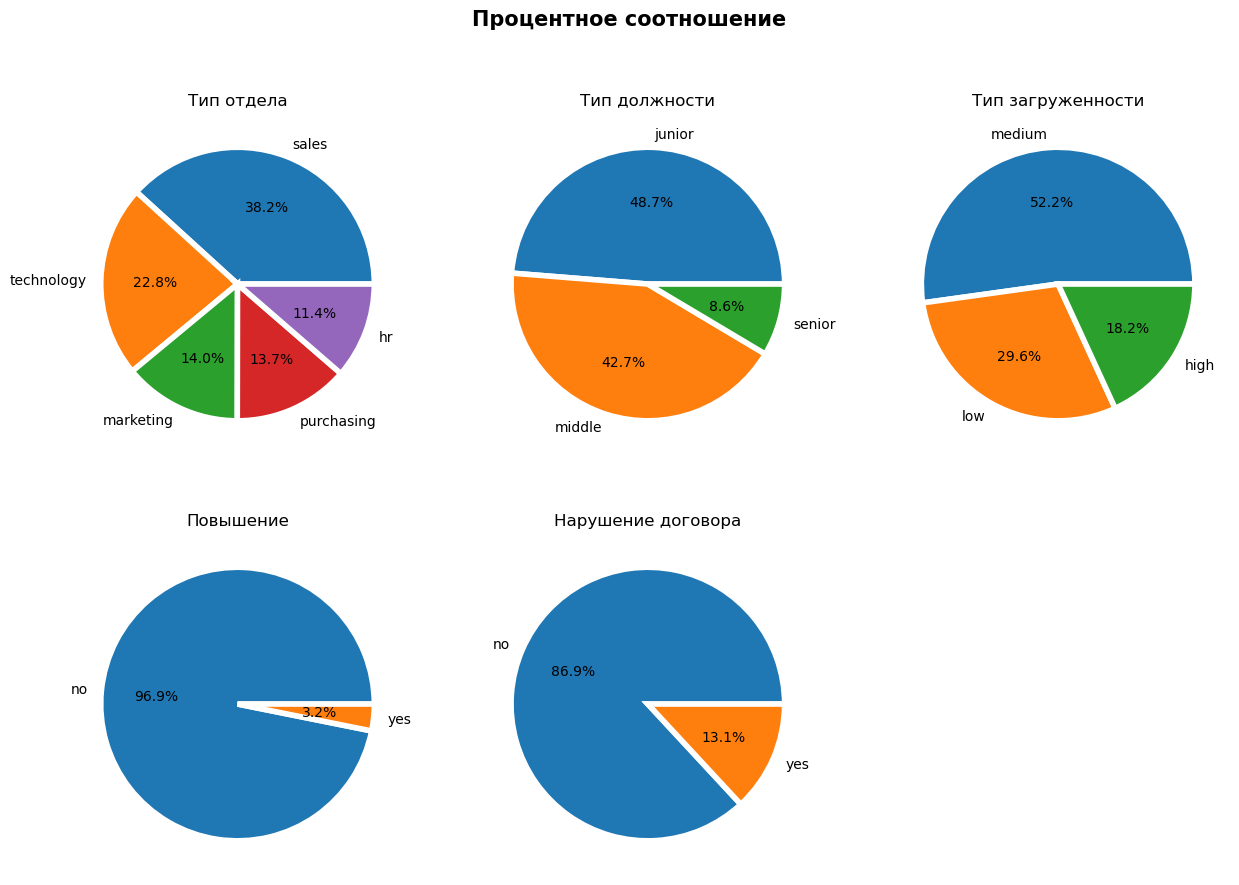

In [46]:
plt.figure(figsize=(15, 10))

plt.suptitle('Процентное соотношение', fontsize=15, fontweight='bold')

plt.subplot(2, 3, 1)
plt.pie(test_features_dept.values,
        labels=test_features_dept.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Тип отдела')

plt.subplot(2, 3, 2)
plt.pie(test_features_level.values,
        labels=test_features_level.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Тип должности')

plt.subplot(2, 3, 3)
plt.pie(test_features_workload.values,
        labels=test_features_workload.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Тип загруженности')

plt.subplot(2, 3, 4)
plt.pie(test_features_promo.values,
        labels=test_features_promo.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Повышение')

plt.subplot(2, 3, 5)
plt.pie(test_features_viol.values,
        labels=test_features_viol.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Нарушение договора')
plt.show()

Исходя из круговых диаграмм можно сказать:

- Больше всего людей работают в отделе `sales` - 38.2%. Меньше всего сотрудников в отделе `hr` - 11.4%
- Больше всего сотрудников уровня `junior` - 48.7%, сотрудников уровня `middle` - 42.7%, меньше всего `senior` - 8.6%
- Большая часть сотрудников имеет среднюю нагржуеность - 52.2%
- Всего у 3.2% сотрудников было повышение за год.
- 13.1% сотрудников нарушали трудовой договор за год.

Данные для тестовой выборки такие же, как и для тренировочной

Изучим количественные переменые.

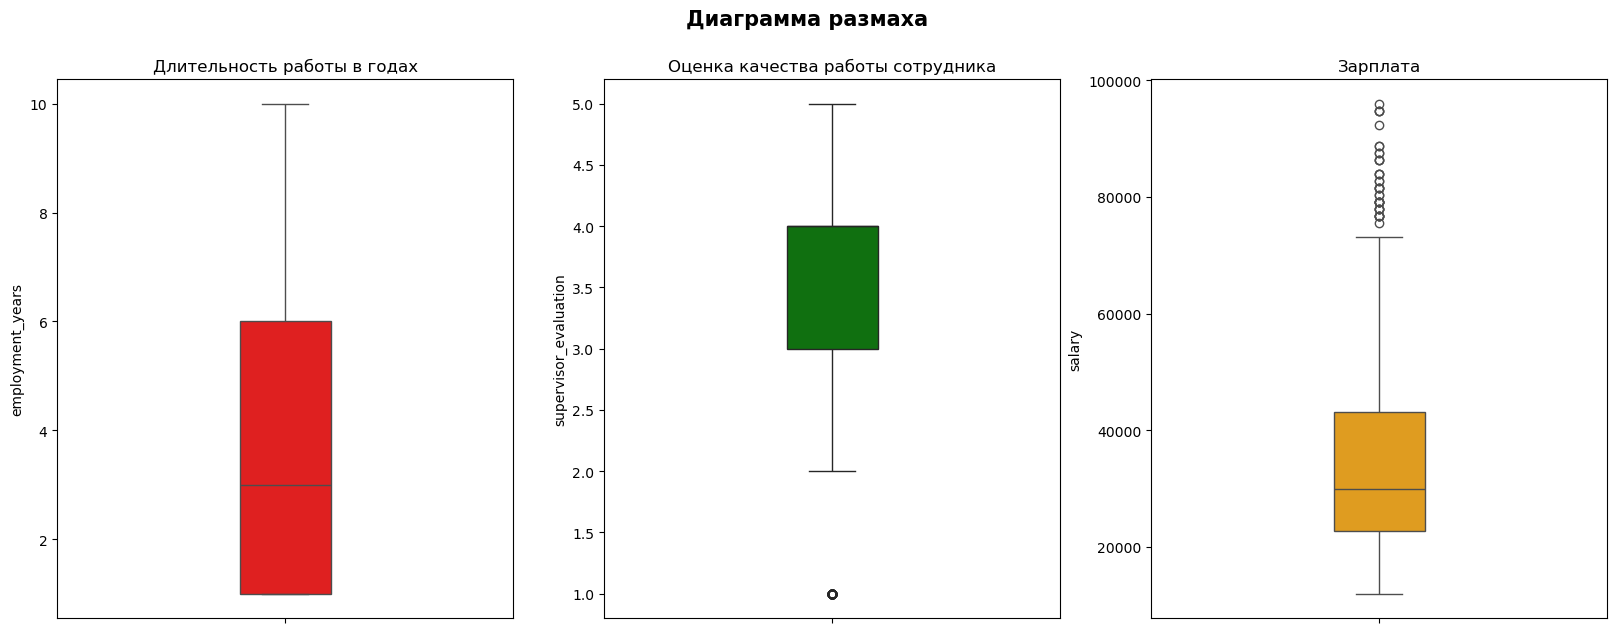

In [47]:
plt.figure(figsize=(20, 7))

plt.suptitle('Диаграмма размаха', fontsize=15, fontweight='bold')

plt.subplot(1, 3, 1)
sns.boxplot(y=test_features['employment_years'], width=.2, color='red')
plt.title('Длительность работы в годах')

plt.subplot(1, 3, 2)
sns.boxplot(y=test_features['supervisor_evaluation'], width=.2, color='green')
plt.title('Оценка качества работы сотрудника')

plt.subplot(1, 3, 3)
sns.boxplot(y=test_features['salary'], width=.2, color='orange')
plt.title('Зарплата')
plt.show()

Анологичная ситуация, как и у тренировчной выборки, есть выбивающиеся значения, но они не являются аномальными. Все значения в допустимом диапазоне.

Построим гистограммы по количественным перменным.

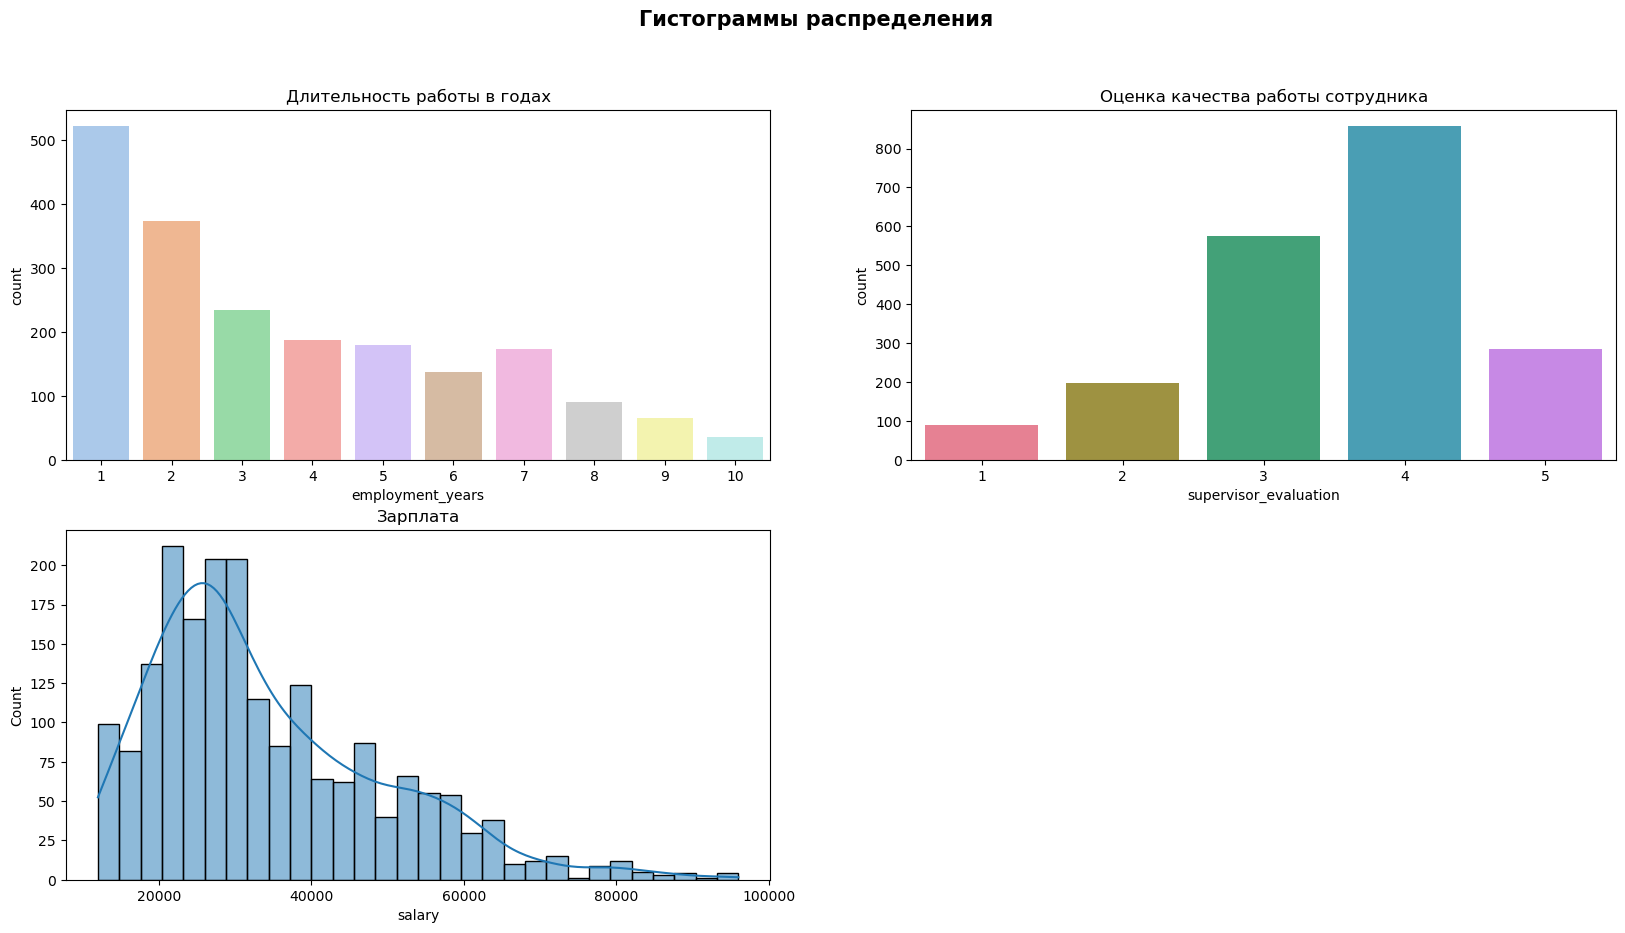

In [48]:
plt.figure(figsize=(20, 10))

plt.suptitle('Гистограммы распределения', fontsize=15, fontweight='bold')

plt.subplot(2, 2, 1)
sns.countplot(x='employment_years', data=test_features, palette='pastel')
plt.title('Длительность работы в годах')

plt.subplot(2, 2, 2)
sns.countplot(x='supervisor_evaluation', data=test_features, palette='husl')
plt.title('Оценка качества работы сотрудника')

plt.subplot(2, 2, 3)
sns.histplot(test_features['salary'], kde=True, bins=30)
plt.title('Зарплата')
plt.show()

Количественные признаки в тестовой выборке также распределены ненормально, как и у тренировочной выборке, график длительности работы похож на асеммитричное распределение, график зарплаты асеммитричное распределение смешенное вправо, а график качества работы тож похож на асеммитричное распределение.

#### Исследуем датафрейм `test_target_rate`.

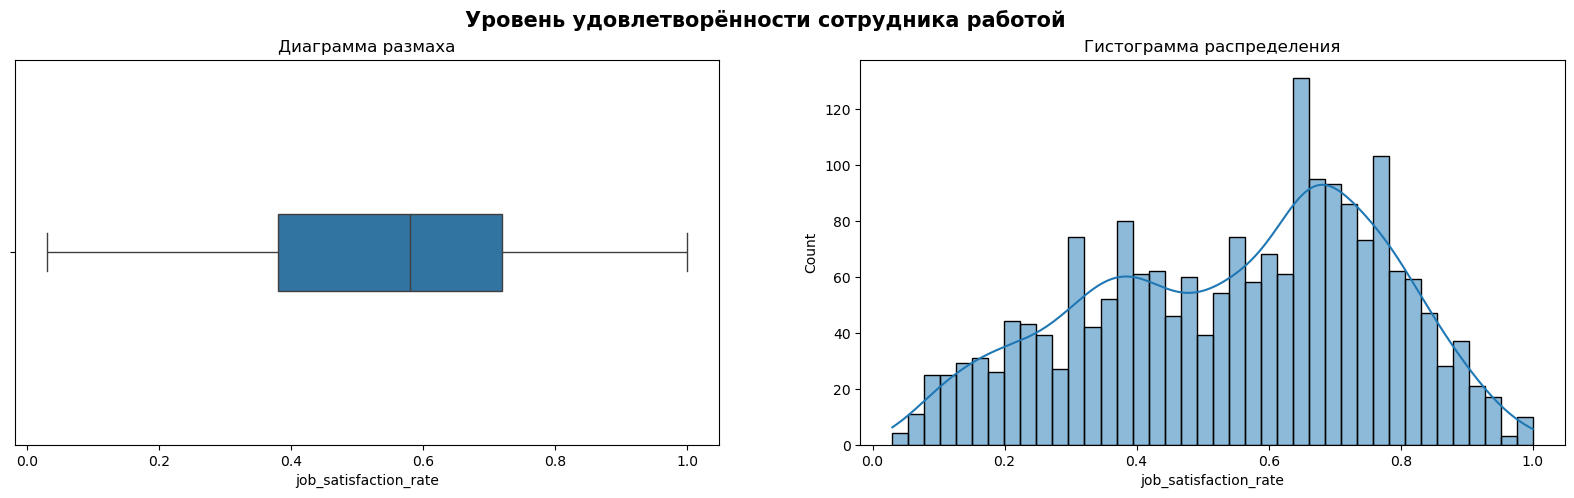

In [49]:
plt.figure(figsize=(20, 5))

plt.suptitle('Уровень удовлетворённости сотрудника работой',
             fontsize=15, fontweight='bold')

plt.subplot(1, 2, 1)
sns.boxplot(x=test_target_rate['job_satisfaction_rate'], width=.2)
plt.title('Диаграмма размаха')

plt.subplot(1, 2, 2)
sns.histplot(test_target_rate['job_satisfaction_rate'], kde=True, bins=40)
plt.title('Гистограмма распределения')
plt.show()

Исходя из графика boxplot аномальных значений нет. А о распределении данных можно судить по гистограмме и можно сказать, что данные также распределенные ненормально.

#### Вывод.

По результатам исследователького анализа можно сделать следующие выводы:

По тренировочной выборке.

1. По типу отдела количество сотрудников расположилось следующим образом:
    - `sales` - 37.9%
    - `technology` - 21.7%
    - `purchasing` - 15.3%
    - `marketing` - 13.8%
    - `hr` - 11.4%
2. Больше всего сотрудников уровня `junior` - 47.4%, но также много сотрудников уровня `middle` - 43.6%, меньше всего `senior` - 9%
3. Нагруженность сотрудников выглядит следующим образом:
    - `medium` - 51.6%
    - `low` - 30%
    - `high` - 18.4%
4. Всего у 3% сотрудников было повышение за год.
5. 14% сотрудников нарушали трудовой договор за год.
6. Хоть в столбцах `supervisor_evaluation` и `salary` были обнаружены выбросы, но эти значения не будут аномальными.
7. Количественные признаки распределены ненормально, график длительности работы похож на асеммитричное распределение, график уровня удовлетворенности сотрудника похож на мультимодальное распределение, график зарплаты асеммитричное распределение смешенное вправо, а график качества работы тож похож на асеммитричное распределение.

По тестовой выборке.

1. По типу отдела количество сотрудников расположилось следующим образом:
    - `sales` - 38.2%
    - `technology` - 22.8%
    - `marketing` - 14%
    - `purchasing` - 13.7%
    - `hr` - 11.4%
2. Больше всего сотрудников уровня `junior` - 48.7%, сотрудников уровня `middle` чуть меньше - 42.7%, меньше всего `senior` - 8.6%
3. Нагруженность сотрудников выглядит следующим образом:
    - `medium` - 52.2%
    - `low` - 29.6%
    - `high` - 18.2%
4. Всего у 3.2% сотрудников было повышение за год.
5. 13.1% сотрудников нарушали трудовой договор за год.
6. По количественным переменым анологичная ситуация, как и у тренировочной выборки, есть выбивающиеся значения, но они не являются аномальными. Все значения в допустимом диапазоне.
7. Распределение количественных переменных такое же как и у тренировчной выборке.
8. Целевой тестовый признак не имеет выборосов, а также распределен ненормально.

Можно сказать, что данные в выборках практически похожи, хоть в тестовой их и меньше, но само распределение данных такое же.

### Корреляционный анализ.

Исходя из исследовательского анализа стало понятно, что данные в нашем датафреме распределены не нормально, поэтому для изучения взаимосвязи между переменнами в таблице `satisfaction_rate` необходимо использовать коэффициент корреляции $\phi_k$, он может находить взаимосвязь между категориальными, порядковыми и интервальными признаками. Чем ближе его значение по модулю к 1, тем сильнее связь.

Расчитаем корреляцию при помощи библиотеки Фик для всех наших признаков.

In [50]:
# Расчитываем коэффициент корреляции Фи
phik_matrix = (
    satisfaction_rate
    .drop(columns='id', axis=1)
    .phik_matrix(interval_cols=['job_satisfaction_rate', 'salary'])
)

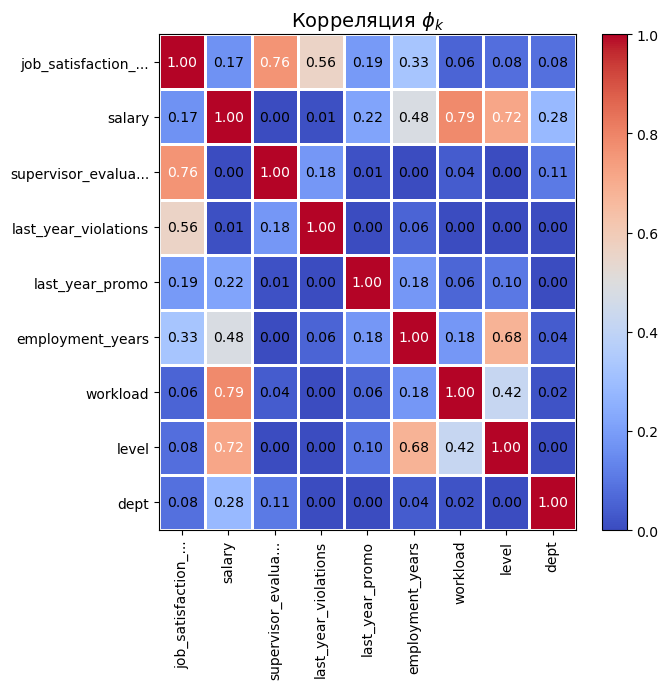

In [51]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(7, 7))
plt.tight_layout()

Наш целевой признак `job_satisfaction_rate` посмотрим как он взаимодействует с входными признаками.

Есть высокая взаимосвязь с `supervisor_evaluation` - 0.76 и хорошая с `last_year_violations` - 0.56 и `employment_years` - 0.33. Также есть слабая взаимосвязь с `salary` - 0.17 и `last_year_promo` - 0.19. С признаками `dep`, `level` и `workload` сложно судить о взаимосвязи - 0.08, 0.08 и 0.06 соотвествено.

Также изучим все взаимосвязи между признаками.

Есть сильная взаимосвязь между `salary` и `workload`, `level` - 0.79 и 0.72 соотвествено.
Признак `employment_years` имеет взаимосвязь с `level` и `salary` - 0.68 и 0.48.
Признак `workload` имеет взаимосвязь с `level` - 0.42.

Мультиколлинеарность между признаками не наблюдается.

In [52]:
# Расчитываем коэффициент корреляции Фи
phik_matrix = (
    test_features
    .drop(columns='id', axis=1)
    .phik_matrix(interval_cols=['salary'])
)

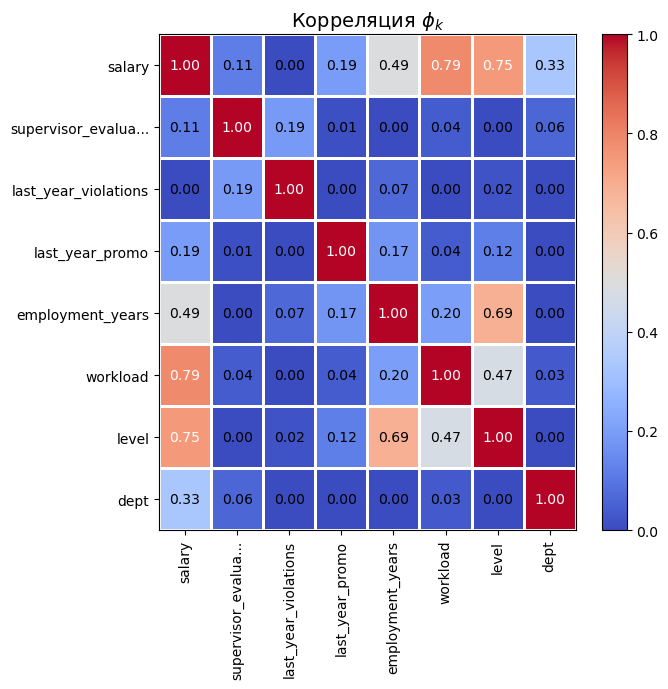

In [53]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(7, 7))
plt.tight_layout()

Посмотрим как взаимосвязаны признаки между собой.
    
Признак `salary` имеет сильную взаимосвязь с `workload` и `level` - 0.79 и 0.75. Слабую взаимосвязь с `employment_years` и `dept` - 0.49 и 0.33
    
Признаки `supervisor_evaluation`, `last_year_violations` и `last_year_promo` практически не имеют взаимосвязи с другими признаками.
    
Признак `employment_years` имеет взаимосвязь с `level` - 0.69
    
Признаки `workload` и `level` имеет между собой взаимосвязь - 0.47

Мультиколлинеарность между признаками не наблюдается.

### Обучение модели.

Закодируем наш целевой признак, представим, что если `job_satisfaction_rate` < 0.5, то тогда сотрудник не удовлетворен работой и мы присваиваем ему `0`, в противном случае ставим `1`. Делаем это для того, чтобы представить задачу в виде задачи бинарной классификации.

В `test_target_rate` и `test_features` одни и теж id стоят в разных строчках. Нам необходимо, чтобы строчки совпадали между собой, поэтому объединим эти два датафрейма по id и перед обучение выделим целевой признак.

In [54]:
test_df = test_features.merge(test_target_rate, on='id', how='outer')

Для обучения модели сначала сделаем предподготовку данных и создадим для этого пайплайн. После приступим к изучению модели и воспользуемся двумя моделями `LinearRegression` и `DecisionTreeRegressor`. Будем подбирать параметры только для дерева решений при помощи `RandomizedSearchCV`. Оценивать модель будем по собсвтенной метрики, которая называется SMAPE - симметричное среднее абсолютное процентное отклонение и для этого была написана функция `custom_metric`.

Подготовим выборки для обчения, удалим сначала столбец `id` и проверим потом на явные дубликаты, если они есть, то удалим их и затем удалим наш целевой признак из обучающейся выборки и еще раз проверим на дубликаты.

In [55]:
X = satisfaction_rate.drop(columns=['id'], axis=1)

In [56]:
X.duplicated().sum()

245

In [57]:
X = X.drop_duplicates().reset_index(drop=True)

In [58]:
y = X[['job_satisfaction_rate']]
X = X.drop(columns=['job_satisfaction_rate'], axis=1)

In [59]:
X.duplicated().sum()

1247

In [60]:
X = X.drop_duplicates()

In [61]:
X = X.join(y, how='inner')

In [62]:
X = X.reset_index(drop=True)

In [63]:
y = X['job_satisfaction_rate']
X = X.drop(columns=['job_satisfaction_rate'], axis=1)

In [64]:
X.duplicated().sum()

0

In [65]:
X_test = test_df.drop(columns=['id', 'job_satisfaction_rate'], axis=1)
y_test = test_df['job_satisfaction_rate']

In [66]:
# Cоздаём списки с названиями признаков
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [67]:
# Cоздаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
                    )

In [68]:
# Создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_ord', SimpleImputer(missing_values=np.nan,  strategy='most_frequent')),
     ('ord', OrdinalEncoder(
         categories=[['junior', 'middle', 'senior'],
                     ['low', 'medium', 'high']],
         handle_unknown='use_encoded_value', unknown_value=np.nan))]
)

In [69]:
# Создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)],
    remainder='passthrough'
)

In [70]:
# Пайплайн data_preprocessor применям к тренировочной, валидационной выборкам.
X_train_p = data_preprocessor.fit_transform(X)

X_test_p = data_preprocessor.transform(X_test)

Инициализиурем нашу метрику

In [71]:
scorer = make_scorer(custom_metric, greater_is_better=False)

Обчаем модель дерево решений и подбираем параметры с помощью `RandomizedSearchCV`.

In [72]:
# Инициализируем модель дерева решений
model_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

# Создаём словарь со значениями гиперпараметров для перебора
parameters_tree = {
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 8)
}

# Инициализируем класс для случайного поиска
randomized_search_tree = RandomizedSearchCV(
    model_tree,
    parameters_tree,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

randomized_search_tree.fit(X_train_p, y)
y_pred_tree = randomized_search_tree.predict(X_train_p)
y_test_tree = randomized_search_tree.predict(X_test_p)

print('Лучшая модель и её параметры:\n\n',
      randomized_search_tree.best_estimator_)
print(f'Метрика SMAPE на кросс-валидации:',
      abs(randomized_search_tree.best_score_))

Лучшая модель и её параметры:

 DecisionTreeRegressor(min_samples_leaf=4, min_samples_split=4, random_state=42)
Метрика SMAPE на кросс-валидации: 18.203746542028277


Обучаем вторую модель - Линейную регресию, для нее  параметры подбирать не будем.

In [73]:
# Инициализируем модель линейной регрессии
model_lr = LinearRegression()

model_lr.fit(X_train_p, y)

sMAPE = cross_val_score(model_lr, X_train_p, y, scoring=scorer).mean()
print('Метрика на кросс-валидации', abs(sMAPE))

Метрика на кросс-валидации 25.185365509990294


По результатам видно, что дерево решений справилось лучше. Теперь проверим эту модель на тестовой выборки, если `sMAPE <= 15`, то мы удовлетворим условию ТЗ.

In [74]:
print(
    f'Метрика SMAPE на тестовой выборке: {abs(scorer(randomized_search_tree, X_test_p, y_test)):.2f}')

Метрика SMAPE на тестовой выборке: 14.02


Метрика на теcтовой - `14.02`, что соотвествует услвоию ТЗ, а значит модель деревьев решения нам подходит

Проверим модель на адекватность

In [75]:
# Инициализируем dummy модель
model_dr = DummyRegressor(strategy='mean')

model_dr.fit(X_train_p, y)

print(
    f'Метрика SMAPE на тестовой выборке: {-scorer(model_dr, X_test_p, y_test):.2f}')

Метрика SMAPE на тестовой выборке: 38.81


Результаты дамми модели хуже почти в 3 раза нашей лучше модели, что говорит в нашу пользу.

Также выведем поважности признаки

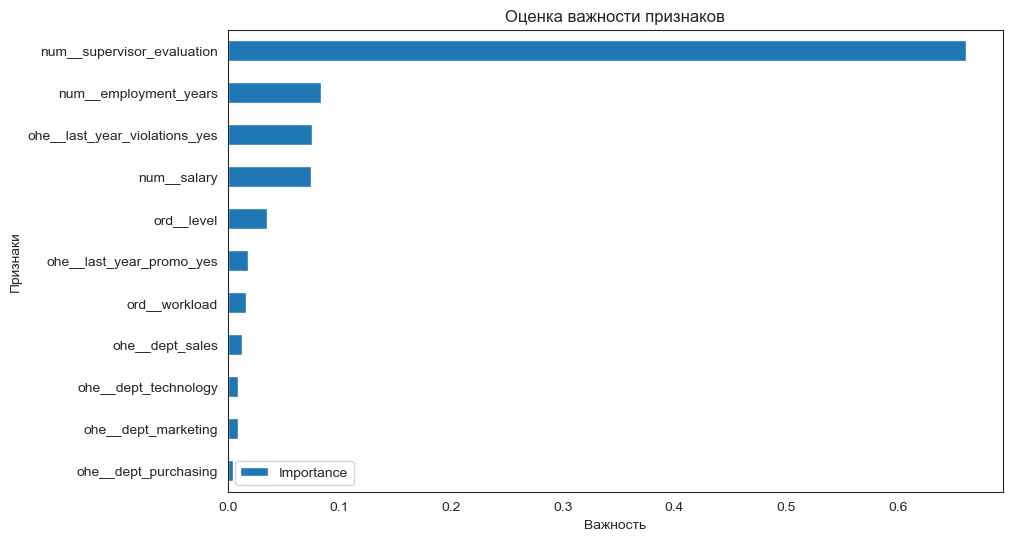

In [76]:
coefficients = randomized_search_tree.best_estimator_.feature_importances_

sns.set_style('white')
feature_importance = pd.DataFrame(
    {'Feature': data_preprocessor.get_feature_names_out(), 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values(
    'Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance',
                        kind='barh', figsize=(10, 6))
plt.title('Оценка важности признаков')
plt.xlabel('Важность')
plt.ylabel('Признаки');

Видно, что очень важным признакам является `supervisor_evaluation`, а также  менене, но также важны `employment_years`, `last_year_violations_yes` и `salary`. Есть и менее важные признаки их не убирал, так как из-за этого качество модели падает.

### Вывод

Необходимый критерий успеха: SMAPE ≤ 15 на тестовой выборке. Обе модели подходят, необходимо выбрать одну из них

Резульаты модели `DecisionTreeRegressor`:
- на кросс-валидации: -18.20
- на тестовой выборке: -14.02

Результаты модели `LogisticRegression`:
- на кросс-валидации: -25.18

Так как нам необходимо, чтобы было SMAPE < 15. То по результатом кросс-валидации была выбрана модель дерева решений, дальше она была проверена на тестовой выборке и SMAPE - 14.02, что соотвествует ТЗ. Также была проведена проверка на адекватность модели и в результате дерево решений практически в 3 раза лучше, чем дамми модель.

Параметры лучшей модели следующие:
- min_samples_leaf=4, 
- min_samples_split=4

## Задача 2

### Изучение данных

Входные признаки тестовой выборки те же, что и в прошлой задаче, а значит используется `test_features`. Необходимо загрузить оставшиеся данные для второй задачи.

In [77]:
pth4 = r"C:\Users\stepa\Downloads\train_quit.csv"
pth5 = r"C:\Users\stepa\Downloads\test_target_quit.csv"

In [78]:
if os.path.exists(pth4):
    train_quit = pd.read_csv(pth4)
else:
    print('Ошибка')

In [79]:
if os.path.exists(pth5):
    test_target_quit = pd.read_csv(pth5)
else:
    print('Ошибка')

Выведем первые 5 строк всех таблиц

In [80]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [81]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Посмотрим на общую информацию о данных в таблицах.

In [82]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [83]:
train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


Рассмотрим полученную информацию подробнее.

Всего в таблице 10 столбцов, тип данных - `int`(4), `object`(6).
Количестов значений в столбцах одинаковое, а значит пропусков нет. Название столбцов соотвествует стилю. Исходя из описательной статистики аномальных значений нет.

In [84]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Рассмотрим полученную информацию подробнее.

Всего в таблице 2 столбца, тип данных - `int`(1), `object`(1).
Количестов значений в столбцах одинаковое, а значит пропусков нет. Название столбцов соотвествует стилю. Описательную статистику нет смысла смотреть, так как она будет только по `id`, а нам данный столбец не нужен.

#### Вывод

Каждая сторка таблиц содержит информацию о сотрудниках. Необходимо сделать следующее:

1. Сделать проверку на явные и неявные дубликаты.

### Предобработка данных
#### Работа с явными дубликатами

In [85]:
train_quit.duplicated().sum()

0

In [86]:
test_target_quit.duplicated().sum()

0

Явных дубликатов не обнаружено.

#### Работа с неявными дубликатами.

Предположим, что в таблице `train_quit` в столбцах, имеющие строковый тип данных, одно и тоже значение переменной может быть написано по-разному, то есть проверим столбцы:
- `dept`	
- `level`	
- `workload`
- `last_year_promo`	
- `last_year_violations`
- `quit`

Также исследуем столбей `quit` в `train_target_quit`.

In [87]:
train_quit_dept = train_quit['dept'].value_counts()
train_quit_dept

dept
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: count, dtype: int64

In [88]:
train_quit['level'].value_counts()

level
junior    1949
middle    1694
sinior     357
Name: count, dtype: int64

Можно заметить, что в `train_quit` в столбце `level` название должности написано неправильно, а именно заменим `sinior` на `senior`.

In [89]:
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')

Проверим результат работы

In [90]:
train_quit_level = train_quit['level'].value_counts()
train_quit_level

level
junior    1949
middle    1694
senior     357
Name: count, dtype: int64

In [91]:
train_quit_workload = train_quit['workload'].value_counts()
train_quit_workload

workload
medium    2118
low       1208
high       674
Name: count, dtype: int64

In [92]:
train_quit_promo = train_quit['last_year_promo'].value_counts()
train_quit_promo

last_year_promo
no     3887
yes     113
Name: count, dtype: int64

In [93]:
train_quit_viol = train_quit['last_year_violations'].value_counts()
train_quit_viol

last_year_violations
no     3455
yes     545
Name: count, dtype: int64

In [94]:
train_quit_quit = train_quit['quit'].value_counts()
train_quit_quit

quit
no     2872
yes    1128
Name: count, dtype: int64

In [95]:
test_target_quit_quit = test_target_quit['quit'].value_counts()
test_target_quit_quit

quit
no     1436
yes     564
Name: count, dtype: int64

Неявные дубликаты не обнаружены.

#### Вывод

На данном этапе были сделаны следующие действия:

1. Сделали проверку на явные дубликаты - **не обнаружены**.
2. Сделали проверку на неявные дубликаты - **не обнаружены**.
3. Исправили ошибку в название должности в столбце `level` в датафреймах `train_quit` c `sinior` на `senior`.

### Исследовательский анализ данных
#### Исследуем данные в  `train_quit`

Исследуем данные в датафрейме `train_quit`:
- Выясним процентное соотношение отделов, уровня должности, уровня загруженности, было ли повышение за последний год и нарушал ли сотрудник трудовой договор за последний год.
- Изучим количественные переменные:  длительность работы в компании, оценка качества работы сотрудника, зарплата и уровень удовлетворённости сотрудника.

Исследуем количественный столбец в датафрейме `test_quit_rate`.

Начнем с анализа таблицы `train_quit` и построим круговые диаграммы.

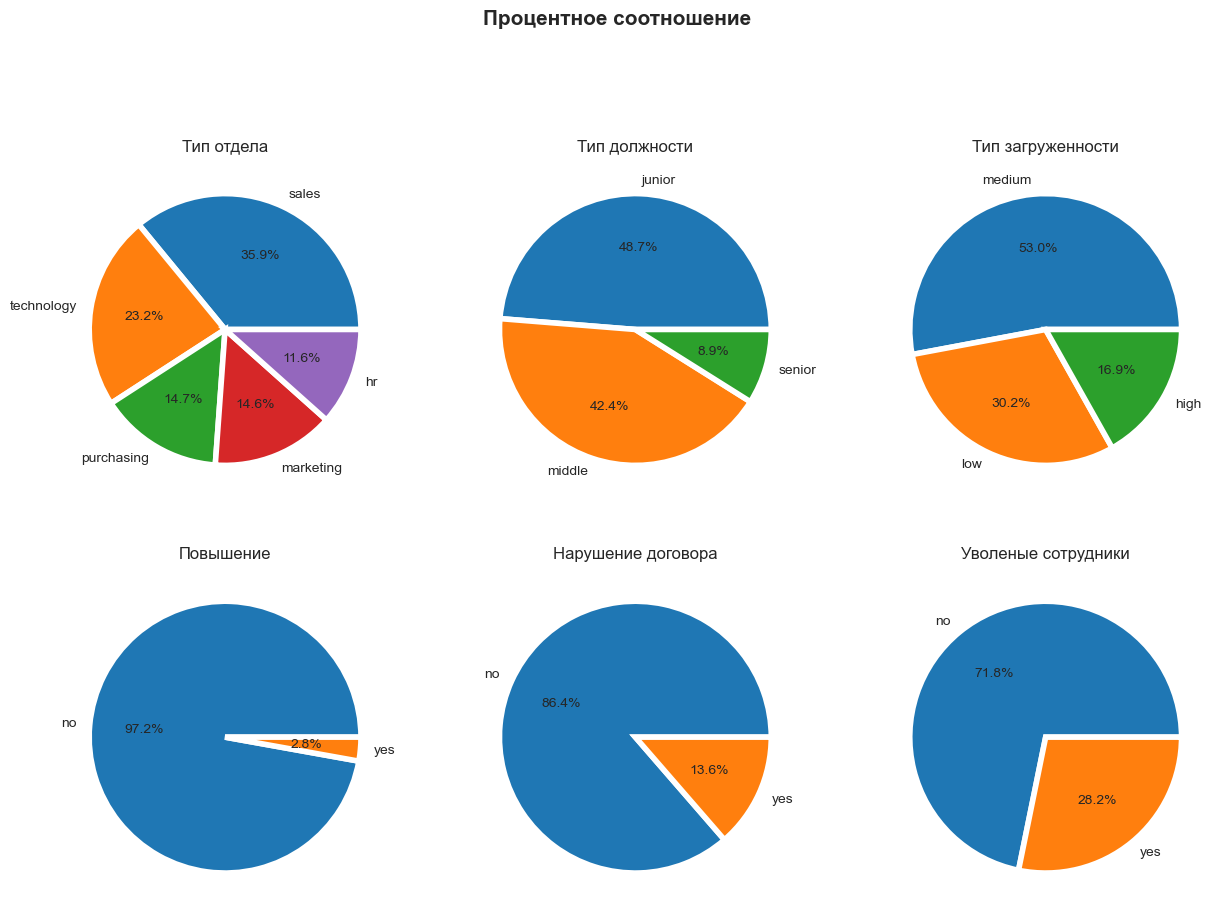

In [96]:
plt.figure(figsize=(15, 15))

plt.suptitle('Процентное соотношение', fontsize=15, fontweight='bold')

plt.subplot(3, 3, 1)
plt.pie(train_quit_dept.values,
        labels=train_quit_dept.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Тип отдела')

plt.subplot(3, 3, 2)
plt.pie(train_quit_level.values,
        labels=train_quit_level.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Тип должности')

plt.subplot(3, 3, 3)
plt.pie(train_quit_workload.values,
        labels=train_quit_workload.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Тип загруженности')

plt.subplot(3, 3, 4)
plt.pie(train_quit_promo.values,
        labels=train_quit_promo.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Повышение')

plt.subplot(3, 3, 5)
plt.pie(train_quit_viol.values,
        labels=train_quit_promo.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Нарушение договора')

plt.subplot(3, 3, 6)
plt.pie(train_quit_quit.values,
        labels=train_quit_quit.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Уволеные сотрудники')
plt.show()

Можно сказать следующие:

- Больше людей работают в отделе `sales` - 35.9%. Меньше всего сотрудников в отделе `hr` - 11.6%
- Больше всего сотрудников уровня `junior` - 48.7%, но также много сотрудников уровня `middle` - 42.4%, меньше всего `senior` - 8.9%
- Большая часть сотрудников имеет среднюю нагржуеность - 53%
- Всего у 2.8% сотрудников было повышение за год.
- 13.6% сотрудников нарушали трудовой договор за год.
- Уволненых сотрудников - 28.2%

Теперь изучим количественные перемены и построим диаграмму размаха.

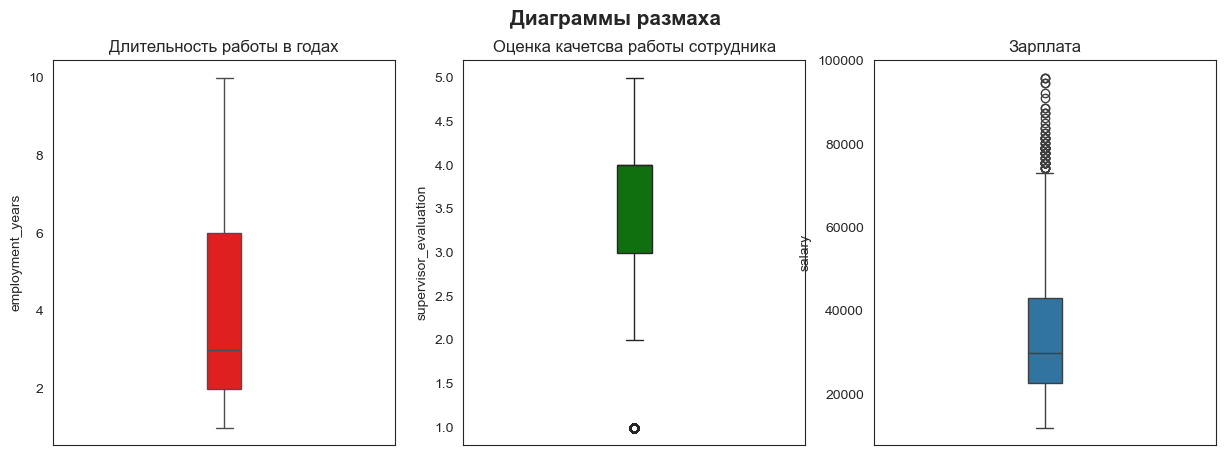

In [97]:
plt.figure(figsize=(15, 5))

plt.suptitle('Диаграммы размаха', fontsize=15, fontweight='bold')

plt.subplot(1, 3, 1)
sns.boxplot(y=train_quit['employment_years'], width=.1, color='red')
plt.title('Длительность работы в годах')

plt.subplot(1, 3, 2)
sns.boxplot(y=train_quit['supervisor_evaluation'], width=.1, color='green')
plt.title('Оценка качетсва работы сотрудника')

plt.subplot(1, 3, 3)
sns.boxplot(y=train_quit['salary'], width=.1)
plt.title('Зарплата')
plt.show()

Из графиков видно, что в столбцах `supervisor_evaluation` и `salary` есть  несколько выбросов, но сами эти значения не будут аномальными. Ситуация точно такая же как и в прошлой задаче, выбросами являются очень низка оценка 1 и это возможно. Тоже самое и с зарплатой, просто есть несколько людей, у которых зарплата намного больше, чем у других, но все находится в пределах нормы. Сотрудник может получать зарплату от 75000 до 100000.

Постром гистограмму распределения

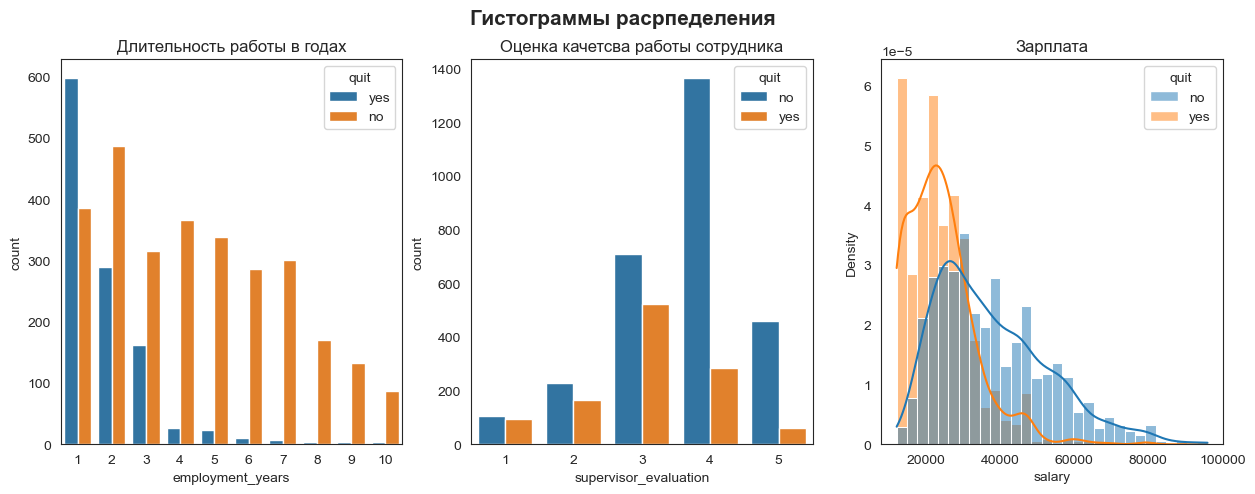

In [98]:
plt.figure(figsize=(15, 5))

plt.suptitle('Гистограммы расрпеделения', fontsize=15, fontweight='bold')

plt.subplot(1, 3, 1)
sns.countplot(data=train_quit, x='employment_years', hue='quit')
plt.title('Длительность работы в годах')

plt.subplot(1, 3, 2)
sns.countplot(data=train_quit, x='supervisor_evaluation', hue='quit')
plt.title('Оценка качетсва работы сотрудника')

plt.subplot(1, 3, 3)
sns.histplot(data=train_quit, x='salary', hue='quit', stat='density',
             common_norm=False, kde=True, bins=30)
plt.title('Зарплата')
plt.show()

Количественные признаки распределены ненормально.

Также можно сказать, что сотрудники, котрые уволились из компании работали в ней немного и чаще всего увольнялись сотрудники проработавшие до 3 лет, реже всего от 7 лет и до 10.

У сотрудников, которые уволились оценка качества работы чаще была от 1 до 3, чем у тех кто остался.

Зарплата у таких сотрудников была обычно меньше, чем у тех кто остался.

#### Исследуем данные в `test_target_quit`

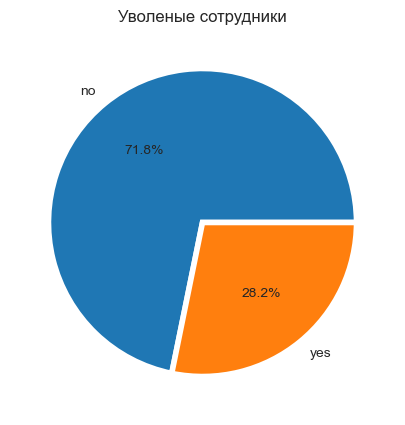

In [99]:
plt.figure(figsize=(20, 5))

plt.pie(test_target_quit_quit.values,
        labels=test_target_quit_quit.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Уволеные сотрудники')
plt.show()

В тестовых данных увольных сотрудников - 28.2%

#### Портрет уволившегося сотрудника

Для того, чтобы составить портрет уволившегося сотрудника, посмотри как зависит увольнения сотрудников в зависимости от отдела, должности, средней зарплаты, загруженности, повышений, нарушений, длительности работы в компании, оценки работы сотрудника и средней зарплаты.

Чтобы посмотреть зависимость увольнения сотрудников от отдела, сделаем группировку по увольнениям. Для того, чтобы дать более точный ответ работает с относительными величинами. Для построенния графика была написана функция `barplot`.

In [100]:
dept_quit = train_quit.groupby('quit')['dept'].value_counts(
    normalize=True).sort_values(ascending=False)

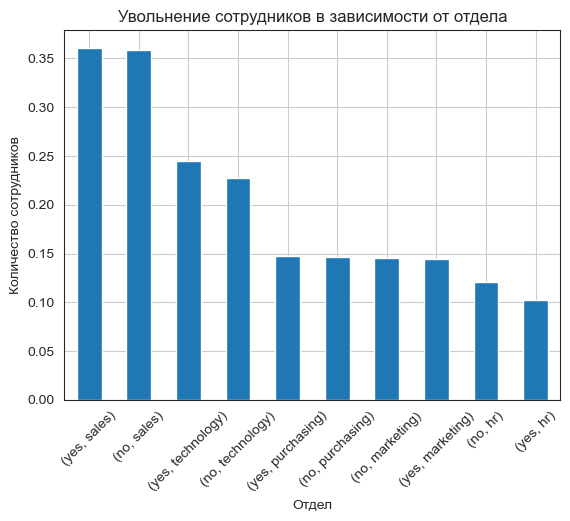

In [101]:
barplot(dept_quit, 'Отдел', 'Увольнение сотрудников в зависимости от отдела')

Больше всего шаннс увольнения из отдела `sales` следом идет `technology`.

Проведем такой же анализ для загруженности, должности, повышений и нарушений

In [102]:
workload_quit = train_quit.groupby('quit')['workload'].value_counts(
    normalize=True).sort_values(ascending=False)

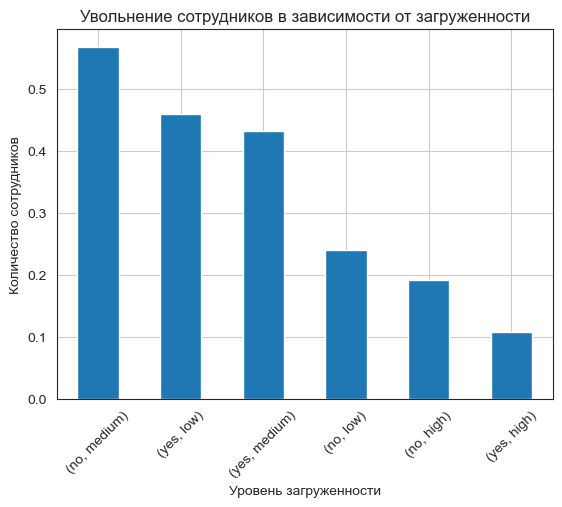

In [103]:
barplot(workload_quit, 'Уровень загруженности',
        'Увольнение сотрудников в зависимости от загруженности')

Наибольший шанс, что сотрудник уволится, если у него низкая загруженность, но с увереностью сказать сложно, скорее всего есть влияние 3-ей переменной

In [104]:
level_quit = train_quit.groupby('quit')['level'].value_counts(
    normalize=True).sort_values(ascending=False)

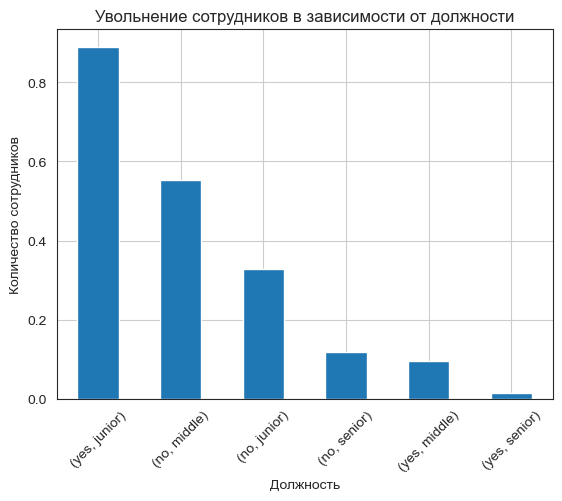

In [105]:
barplot(level_quit, 'Должность',
        'Увольнение сотрудников в зависимости от должности')

Если сотрудник на позиции `junior` то у него самая большая вероятность на увольнение.

In [106]:
promo_quit = train_quit.groupby('quit')['last_year_promo'].value_counts(
    normalize=True).sort_values(ascending=False)

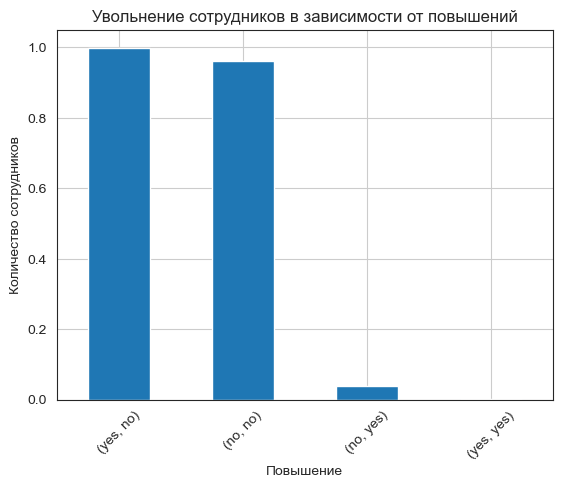

In [107]:
barplot(promo_quit, 'Повышение',
        'Увольнение сотрудников в зависимости от повышений')

Увольнение сотрудника скорее всего не зависит от повышений, скорее всего здесь также должно быть влияние 3ей переменной

In [108]:
viol_quit = train_quit.groupby('quit')['last_year_violations'].value_counts(
    normalize=True).sort_values(ascending=False)

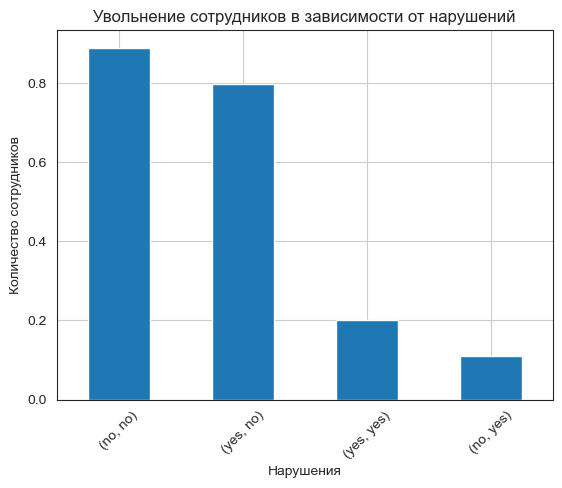

In [109]:
barplot(viol_quit, 'Нарушения',
        'Увольнение сотрудников в зависимости от нарушений')

Увольнение сотрудников не зависит от того нарушали-ли они трудовой договор.

In [110]:
eval_quit = train_quit.groupby('quit')['supervisor_evaluation'].value_counts(
    normalize=True).sort_values(ascending=False)

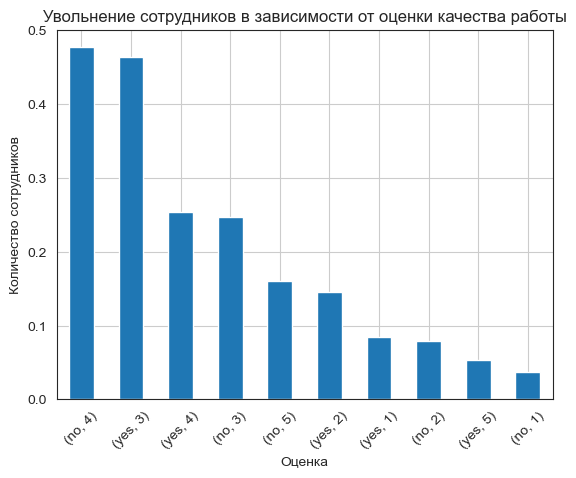

In [111]:
barplot(eval_quit, 'Оценка',
        'Увольнение сотрудников в зависимости от оценки качества работы')

Если сотрудник обычно получает оценку 3, то у него самая большая вероятность на увольнение.

In [112]:
empl_quit = train_quit.groupby('quit')['employment_years'].value_counts(
    normalize=True).sort_values(ascending=False)

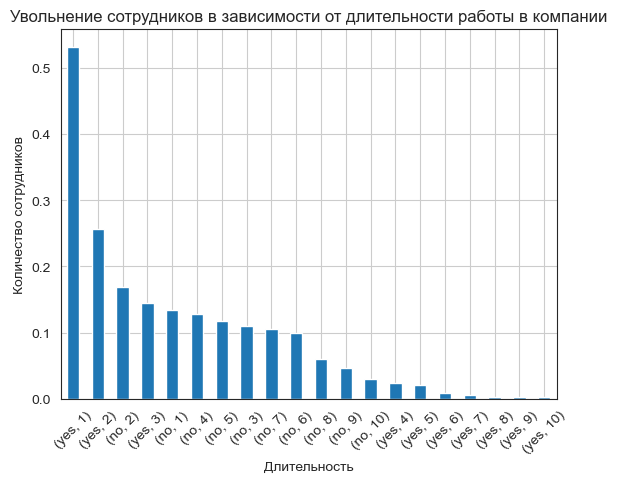

In [113]:
barplot(empl_quit, 'Длительность',
        'Увольнение сотрудников в зависимости от длительности работы в компании')

Больше всего шансов на увольнения у сотрудников, которы проработали в компании 1 и 2 года.

In [114]:
train_quit.groupby('quit')['salary'].agg('mean').value_counts(normalize=True)

salary
37702.228412    0.5
23885.106383    0.5
Name: proportion, dtype: float64

Зарплата уволившихся сотрудников в среднем хоть и меньше, чем у их колег, но она не влияет на увольнение.

**Вывод**

По результатам исследования можно составить следующий портрет ушедшего сотрудника. Сотрулник недавно в компании и работает от года до 2 лет в ней. Обычно должность у него `junior` и оценка сотрудника 3.  Он работает в отделе `technology` или `sales`. Если у него загруженность `low` шанс на увольнения больше всего. Зарплата таких сотрудников в среднем хоть и меньше, чем у их колег, но она не влияет на увольнение.

#### Зависит ли уход сотрудника от удовлетворенности сотрудника работой

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение и построим гистограмму распределения в зависимости от увольнения по признаку `job_satisfaction_rate`

In [115]:
satisfaction_rate_quit = test_features.copy()

In [116]:
satisfaction_rate_quit['job_satisfaction_rate'] = test_target_rate['job_satisfaction_rate']

In [117]:
satisfaction_rate_quit['quit'] = test_target_quit['quit']

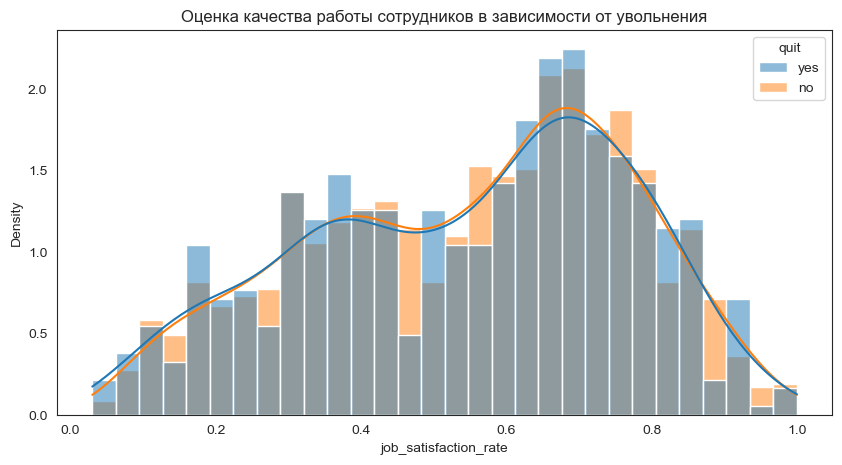

In [118]:
plt.figure(figsize=(10, 5))
sns.histplot(data=satisfaction_rate_quit, x='job_satisfaction_rate', hue='quit', stat='density',
             common_norm=False, kde=True, bins=30)
plt.title('Оценка качества работы сотрудников в зависимости от увольнения')
plt.show()

Как видно из гистограммы, данные распределены одинаково, что может говорить о том, что увольнения сотрудника не зависит от оценки качества работы. Но чтобы лучше убедится в этом выдвинием гипотезы и воспользуемся `ttest` для независимых выборок.

Чтобы убедится есть ли зависимость, выдвинем гипотезу. Выборка μ1 - сотрудник уволился и μ2 - сотрудник не уволился. То нулевая гипотеза будет говорить о равенстве средних выборок. Альтернативная гипотеза будет говорить, что они не равны, то есть двухстороняя гипотеза.
    
- **H0** - μ1=μ2

- **H1** - μ1≠μ2
    
Так как мы сравниваем две разные группы уволившихся и не уволившихся сотрудников и никаких действий с выборкой не происходило, то есть нет выборки до и после, то у нас не зависимые выборки.

In [119]:
alpha = 0.05

result_quit = (
    st.ttest_ind(
        satisfaction_rate_quit[satisfaction_rate_quit['quit']
                               == 'no']['job_satisfaction_rate'],
        satisfaction_rate_quit[satisfaction_rate_quit['quit']
                               == 'yes']['job_satisfaction_rate'],
        equal_var=False,
        alternative='two-sided')
)


print('Среднее значение продолжительности поездки пользователей с подпиской',
      satisfaction_rate_quit[satisfaction_rate_quit['quit'] == 'no']['job_satisfaction_rate'].mean())
print('Среднее значение продолжительности поездки пользователей без подписки',
      satisfaction_rate_quit[satisfaction_rate_quit['quit'] == 'yes']['job_satisfaction_rate'].mean())

print('p-значение:', result_quit.pvalue)

if (result_quit.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Среднее значение продолжительности поездки пользователей с подпиской 0.5501323119777158
Среднее значение продолжительности поездки пользователей без подписки 0.5453368794326242
p-значение: 0.6627988833532199
Не отвергаем нулевую гипотезу


В результате мы не можем отвергнуть нулевую гипотезу, а значит есть основния говорить о том, что **увольнения сотрудников не зависят от оценки качества работы сотрудников**.

#### Вывод

По результатам исследователького анализа можно сделать следующие выводы:

По тренировочной выборке -`train_quit`.

1. По типу отдела количество сотрудников расположилось следующим образом:
    - `sales` - 35.9%
    - `technology` - 23.2%
    - `purchasing` - 14.7%
    - `marketing` - 14.6%
    - `hr` - 11.6%
2. Больше всего сотрудников уровня `junior` - 48.7%, сотрудников уровня `middle` чуть меньше - 42.4%, меньше всего `senior` - 8.9%
3. Нагруженность сотрудников выглядит следующим образом:
    - `medium` - 53%
    - `low` - 30.2%
    - `high` - 16.9%
4. Всего у 2.8% сотрудников было повышение за год.
5. 13.6% сотрудников нарушали трудовой договор за год.
6. Хоть в столбцах `supervisor_evaluation` и `salary` были обнаружены выбросы, но эти значения не будут аномальными.
7. Количественные признаки распределены ненормально. Также можно сказать, что сотрудники, котрые уволились из компании работали в ней немного и чаще всего увольнялись сотрудники проработавшие до 2 лет, реже всего от 7 лет и до 10. У сотрудников, которые уволились оценка качества работы чаще была от 1 до 3, чем у тех кто остался. Зарплата у таких сотрудников была обычно меньше, чем у тех кто остался.


На основе исследовательского анализа был составлен предполагаемый портерт уволившегося сотрудника. Для этого посмотрели как зависит увольнения сотрудников в зависимости от отдела, средней зарплаты и загруженности, а также нашли вероятность увольнения в зависимости от этого.

В результате пришли к следующим преположениям можно составить следующий портрет ушедшего сотрудника. 
- Работает в компании до 3-ех лет
- Работает в отделе `technology` или `sales`
- У него маленькая загруженность - `low`
- Средняя зарплата 24000
- Оценка его работы от 1 до 3.


Также проверили утверждение аналитиков, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. В результате пришли к выводу, что данное утверждение ошибочное и оценка работы не являтся главным фактором увольнения сотрудника.

### Добавление нового входного признака.

По заданию мы допускаем, что `job_satisfaction_rate` и `quit` действительно связаны. И тогда нам необходимо добавить `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

У нас есть предсказания на косс-валидации. Теперь сделаем предсказания на тренировочной выборке и добавим их в `train_quit`. Предсказания для тестовой у нас уже получены и мы добавим их в `test_features`. Лучшей моделью в предыдущей задаче была выбрана DecisionTreeRegressor

In [120]:
df_no_id = satisfaction_rate.drop(columns=['id'], axis=1)

In [121]:
df_no_id_p = data_preprocessor.transform(df_no_id)

In [122]:
job_rate_pred = randomized_search_tree.predict(df_no_id_p)

In [123]:
train_quit['job_satisfaction_rate'] = job_rate_pred

Тоже самое сделаем для тестовой выборки, у нас уже получены предсказания в предыдущей задаче 

In [124]:
test_features['job_satisfaction_rate'] = y_test_tree

Аналогичная ситуация, как раньше, id стоят на разных строках, поэтому объединим тестовые входны и целевой по id.

In [125]:
test_quit = test_features.merge(test_target_quit, on='id', how='outer')

### Корреляционные анализ

Исходя из исследовательского анализа стало понятно, что данные в нашем датафреме распределены не нормально, поэтому для изучения взаимосвязи между переменнами в таблице `train_quit` необходимо использовать коэффициент корреляции $\phi_k$.

In [126]:
# Расчитываем коэффициент корреляции Фи
phik_matrix_quit = (
    train_quit
    .drop(columns='id', axis=1)
    .phik_matrix(interval_cols=['job_satisfaction_rate', 'salary'])
)

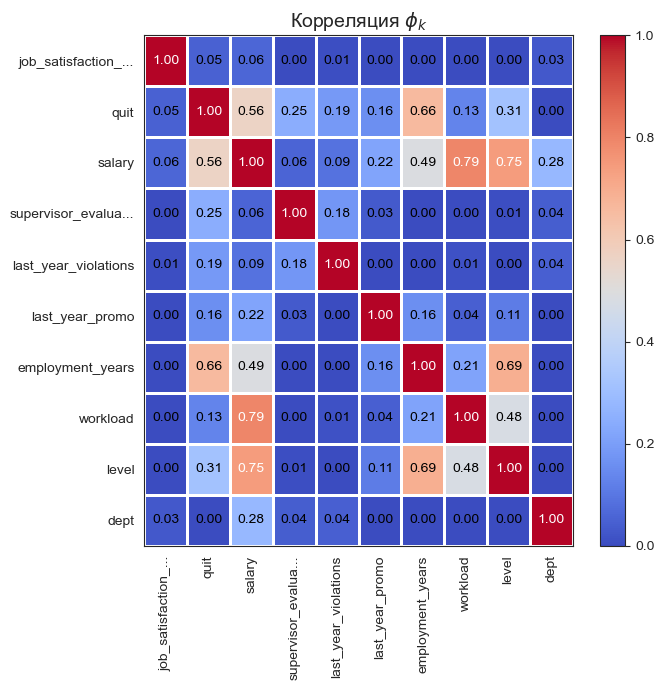

In [127]:
plot_correlation_matrix(phik_matrix_quit.values, x_labels=phik_matrix_quit.columns, y_labels=phik_matrix_quit.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(7, 7))
plt.tight_layout()

Наш целевой признак `quit` посмотрим как он взаимодействует с входными признаками.

Есть хорошая взаимосвязь с `employment_years` - 0.66 и хорошая с `salary` - 0.56. Также есть слабая взаимосвязь с `level` -0.31, `supervisor_evaluation` - 0.25, `last_year_violations` - 0.19, `last_year_promo` - 0.16 и `workload` - 0.13. С признаками `dept`, `job_satisfaction_rate` взаимосвязь отсутсвует 0 и 0.05.

Также изучим все взаимосвязи между признаками.

Есть сильная взаимосвязь между `salary` и `workload`, `level` - 0.79 и 0.75 соотвествено.
Признак `employment_years` имеет взаимосвязь с `level` и `salary` - 0.69 и 0.49
Признак `workload` имеет взаимосвязь с `level` - 0.48

Мультиколлинеарность между признаками не наблюдается.

Сделаем тоже самое для тестовой выбокри.

In [128]:
# Расчитываем коэффициент корреляции Фи
phik_matrix_quit_t = (
    test_quit
    .drop(columns='id', axis=1)
    .phik_matrix(interval_cols=['job_satisfaction_rate', 'salary'])
)

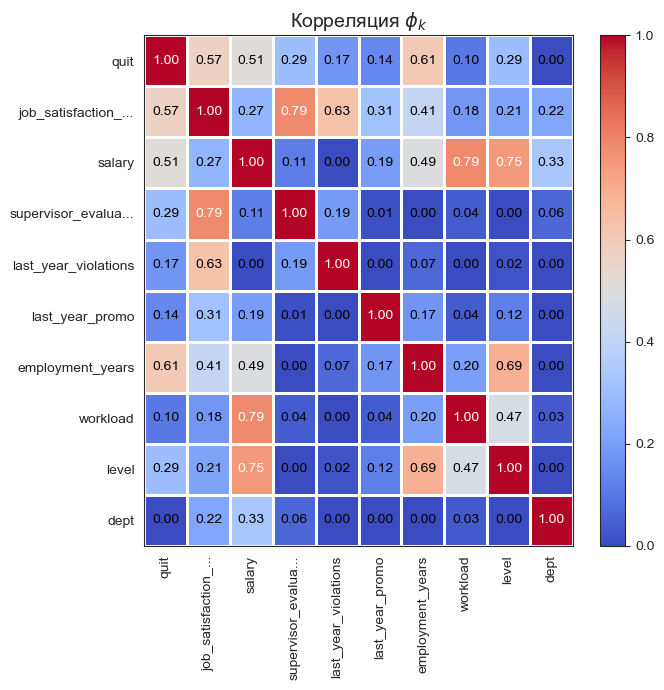

In [129]:
plot_correlation_matrix(phik_matrix_quit_t.values, x_labels=phik_matrix_quit_t.columns, y_labels=phik_matrix_quit_t.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(7, 7))
plt.tight_layout()

Наш целевой признак `quit`, посмотрим как он взаимодействует с входными признаками.

Есть хорошая взаимосвязь с `employment_years` - 0.61 и хорошая с `job_satisfaction_rate` и `salary` - 0.57 и 0.51. Также есть слабая взаимосвязь с `level` - 0.29, `supervisor_evaluation` - 0.29, `last_year_violations` - 0.17, `last_year_promo` - 0.14 и `workload` - 0.10. С признакам `dept` взаимосвязь отсутсвует 0.

Признак `salary` имеет сильную взаимосвязь с `workload` и `level` - 0.79 и 0.75. Слабую взаимосвязь с `employment_years`, `dept` и `job_satisfaction_rate`  - 0.49, 0.33 и 0.27
    
Признаки `supervisor_evaluation`, `last_year_violations` и `last_year_promo` имеют взаимосвязь с `job_satisfaction_rate` - 0.79, 0.63 и 0.31, а также имеют слабую взаимосвязь между собой.
    
Признак `employment_years` имеет взаимосвязь с `level` - 0.69 и слабую взаимосвязь с `job_satisfaction_rate`, `workload` и `last_year_promo` - 0.41, 0.20 и 0.17
    
Признаки `workload` и `level` имеет между собой взаимосвязь - 0.47 и слабую взаимосвязь с `job_satisfaction_rate` - 0.18 и 0.21

Признак `dept` имеет взаимосвязь с `job_satisfaction_rate` - 0.22

Мультиколлинеарность между признаками не наблюдается.

### Обучение модели

Сделаем подготовку тренировочной выборки, как и в предыдущей задаче.

In [130]:
X_train_quit = train_quit.drop(columns='id', axis=1)

In [131]:
X_train_quit = X_train_quit.drop_duplicates().reset_index(drop=True)

In [132]:
y_train_quit = X_train_quit['quit']
X_train_quit = X_train_quit.drop(columns='quit', axis=1)

In [133]:
X_train_quit.duplicated().sum()

4

Эти 4 дубликата оставляем

Выделим целевой признак из тестовой и удалим `id`

In [134]:
X_test_quit = test_quit.drop(columns=['id', 'quit'], axis=1)
y_test_quit = test_quit['quit']

Предподготовка данных все также будет проходить в пайплайне. После приступим к изучению модели и воспользуемся тремя моделями `LogisticRegression`, `DicisionTreeClassifier` и `SVC` и будем подбирать для них параметры при помощи `RandomizedSearchCV`. Оценивать модель будем по метрике `ROC-AUC`, так как эта метрика классификации учитывает работу модели при всех возможных значениях порогов в отличие от других.

In [135]:
# Создаём списки с названиями признаков
lab_columns = ['quit']
ohe_columns_q = ['last_year_promo', 'last_year_violations',
                 'job_satisfaction_rate', 'dept']
ord_columns_q = ['level', 'workload']
num_columns_q = ['employment_years', 'supervisor_evaluation', 'salary']

In [136]:
# Создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe_q = Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                       ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
                      )

In [137]:
# Создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe_q = Pipeline(
    [('simpleImputer_ord', SimpleImputer(missing_values=np.nan,  strategy='most_frequent')),
     ('ord', OrdinalEncoder(
         categories=[['junior', 'middle', 'senior'],
                     ['medium', 'low', 'high']],
         handle_unknown='use_encoded_value', unknown_value=np.nan))]
)

In [138]:
# Создаём общий пайплайн для подготовки данных
data_preprocessor_q = ColumnTransformer(
    [('ohe', ohe_pipe_q, ohe_columns_q),
     ('ord', ord_pipe_q, ord_columns_q),
     ('num', StandardScaler(), num_columns_q)],
    remainder='passthrough'
)

In [139]:
# Пайплайн data_preprocessor применяем к тренировочной, тестовой выборкам.
X_train_pq = data_preprocessor_q.fit_transform(X_train_quit)

X_test_pq = data_preprocessor_q.transform(X_test_quit)

C помощью LabelEncoder закодируем целевой признак

In [140]:
label_encod = LabelEncoder()

y_train_pq = label_encod.fit_transform(y_train_quit)

y_test_pq = label_encod.transform(y_test_quit)

Обчаем модель дерево решений и подбираем параметры с помощью `RandomizedSearchCV`.

In [141]:
# Инициализируем модель дерева решений
model_tree_q = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Создаём словарь со значениями гиперпараметров для перебора
parameters_tree_q = {
    'min_samples_split': range(2, 7),
    'min_samples_leaf': range(1, 7),
    'max_depth': range(2, 7)
}

# Инициализируем класс для случайного поиска
randomized_search_tree_q = RandomizedSearchCV(
    model_tree_q,
    parameters_tree_q,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

randomized_search_tree_q.fit(X_train_pq, y_train_pq)

y_test_treeq = randomized_search_tree_q.predict_proba(X_test_pq)

print('Лучшая модель и её параметры:\n\n',
      randomized_search_tree_q.best_estimator_)
print(f'Метрика ROC-AUC на кросс-валидации:',
      randomized_search_tree_q.best_score_)

Лучшая модель и её параметры:

 DecisionTreeClassifier(max_depth=5, min_samples_leaf=6, min_samples_split=5,
                       random_state=42)
Метрика ROC-AUC на кросс-валидации: 0.9226541615425949


Теперь обучим `LogisticRegression`

In [142]:
# Инициализируем модель дерева решений
model_lr = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')

# Создаём словарь со значениями гиперпараметров для перебора
parameters_lr = {
    'penalty': ['l1', 'l2'],
    'C': range(1, 5)
}

randomized_search_lr = RandomizedSearchCV(
    model_lr,
    parameters_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

randomized_search_lr.fit(X_train_pq, y_train_pq)

y_pred_test_lrq = randomized_search_lr.predict_proba(X_test_pq)

print('Лучшая метрика и ёё параметры:\n\n',
      randomized_search_lr.best_estimator_)
print(f'Метрика ROC-AUC на кросс-валидации:', randomized_search_lr.best_score_)

Лучшая метрика и ёё параметры:

 LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')
Метрика ROC-AUC на кросс-валидации: 0.915066517250567


Обучаем с помощью метода опорных векторов

In [143]:
# Инициализируем модель опроных векторов
model_svc = SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)

In [144]:
# Инициализируем модель опроных векторов
model_svc = SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)

# Создаём словарь со значениями гиперпараметров для перебора
parameters_svc = {
    'gamma': range(1, 5),
    'C': range(1, 5)
}

randomized_search_svc = RandomizedSearchCV(
    model_svc,
    parameters_svc,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

randomized_search_svc.fit(X_train_pq, y_train_pq)

y_pred_valid_svc = randomized_search_svc.predict_proba(X_train_pq)
y_pred_test_svc = randomized_search_svc.predict_proba(X_test_pq)

print('Лучшая метрика и ёё параметры:\n\n',
      randomized_search_svc.best_estimator_)
print(f'Метрика ROC-AUC на кросс-валидации:',
      randomized_search_svc.best_score_)

Лучшая метрика и ёё параметры:

 SVC(C=1, gamma=1, probability=True, random_state=42)
Метрика ROC-AUC на кросс-валидации: 0.9133137293006562


В результате получаем, что лучшая модель по кросс-валидации это деревья решений с ROC-AUC = 0.9226. Теперь проверим ее на тестовой выборки.

In [145]:
print(
    f'Метрика ROC-AUC для деревеьев на тестовой выборке {roc_auc_score(y_test_pq, y_test_treeq[:,1]):.4f}')

Метрика ROC-AUC для деревеьев на тестовой выборке 0.9151


Проверим лучшую модель на адекватность

In [146]:
model_dr2 = DummyClassifier(strategy='uniform')

model_dr2.fit(X_train_pq, y_train_pq)

y_pred_dummy = model_dr2.predict_proba(X_test_pq)

print(
    f'Метрика ROC-AUC на тестовой выборке {roc_auc_score(y_test_pq, y_pred_dummy[:,1]):.4f}')

Метрика ROC-AUC на тестовой выборке 0.5000


Результаты дамми модели хуже нашей лучше модели, что говорит в нашу пользу.

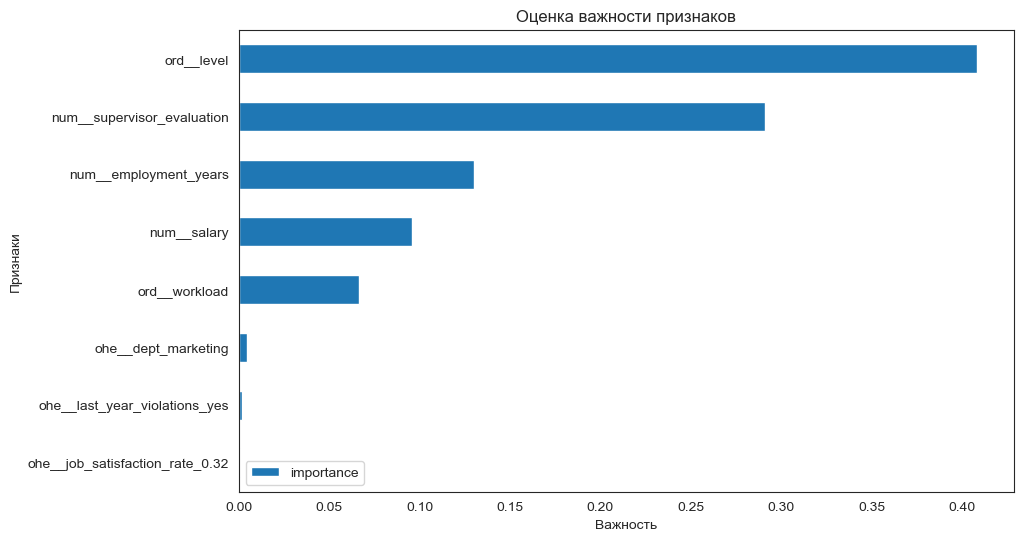

In [147]:
coefficients = randomized_search_tree_q.best_estimator_.feature_importances_

sns.set_style('white')
feature_importance = pd.DataFrame({'feature': data_preprocessor_q.get_feature_names_out(),
                                   'importance': np.abs(coefficients)})
feature_importance = (
    feature_importance
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)
(
    feature_importance.loc[:7]
    .sort_values(by='importance', ascending=True)
    .plot(x='feature', y='importance', kind='barh', figsize=(10, 6))
)
plt.title('Оценка важности признаков')
plt.xlabel('Важность')
plt.ylabel('Признаки');

Самыми важными признаками являются `level`, `supervisor_evaluation`, `employment_years`, `salary` и `workload`.

### Вывод

Необходимый критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке. Было обучено 3 модели, посмотрим на их результат.

Резульаты модели `DecisionTreeClassifier`:
- на кросс-валдиации: 0.9226

Результаты модели `LogisticClassifier`:
- на кросс-валдиации: 0.9151

Результаты модели `SVC`:
- на кросс-валдиации: 0.9131



Исходя из кросс-валидации лучшая модель получается - деревья решений и ее результат на тестовой выборке 0.9151, что удовлетворяет критерию успеха.

Самыми важными признаками по мнению модели являются - `level`, `supervisor_evaluation`, `employment_years`, `salary` и `workload`.

##  Общий вывод

Данные были получены из шести файлов.

Для задачи 1:
- `train_job_satisfaction_rate.csv`;
- `test_features`;
- `test_target_job_satisfaction_rate.csv`.

Для задачи 2:
- `train_quit.csv`;
- `test_features`;
- `test_target_quit.csv`.

Сначала был сделан обзор данных. Само исследование проходило в 3 этап:
1. Задача 1:
    1. Изучить данные.
    2. Предаброботка данных.
    3. Исследовательский анализ данных.
    4. Корреляционный анализ.
    5. Обучение модели.
    6. Вывод.

2. Задача 2:
    1. Изучить данные.
    2. Предаброботка данных.
    3. Исследовательский анализ данных.
    4. Корреляционный анализ.
    5. Обучение модели.
    6. Вывод.

3. Общий вывод.

**1. Задача 1**

**1. Обзор данных.**

- В таблице `satisfaction_rate` - 10 столбцов, тип данных - `int`(4), `object`(5), `float`(1). В столбцах `level` и `dept` есть пропуски. Название столбцов соотвествует стилю. Исходя из данных аномальных значений нет.
  
- В таблице `test_features` - 9 столбцов, тип данных - `int`(4), `object`(5). В столбцах `level` и `dept` есть пропущенные значения. Название столбцов соотвествует стилю. Исходя из данных аномальных значений нет

- В таблице `test_target_rate` - 2 столбца, тип данных - `int`(1), `float`(1). Пропусков нет. Название столбцов соотвествует стилю.

**2. Предаброботка данных.**

Сделали проверку на явные дубликаты - **не обнаружены**.

Сделали проверку на неявные дубликаты - **не обнаружены**.

Исправили ошибку в название должности в столбце `level` в датафреймах `satisfaction_rate`и `test_features` c `sinior` на `senior`.

В датафрейме `test_features` в столбцах `dept` и `workload` были обнаружены пустые значения и заполнили их модой. Столбец `workload` заполнялся модой в зависимости от загружености по должности.

**3. Исследовательский анализ данных.**

По тренировочной выборке.

1. По типу отдела количество сотрудников расположилось следующим образом:
    - `sales` - 37.9%
    - `technology` - 21.7%
    - `purchasing` - 15.3%
    - `marketing` - 13.8%
    - `hr` - 11.4%
2. Больше всего сотрудников уровня `junior` - 47.4%, но также много сотрудников уровня `middle` - 43.6%, меньше всего `senior` - 9%
3. Нагруженность сотрудников выглядит следующим образом:
    - `medium` - 51.6%
    - `low` - 30%
    - `high` - 18.4%
4. Всего у 3% сотрудников было повышение за год.
5. 14% сотрудников нарушали трудовой договор за год.
6. Хоть в столбцах `supervisor_evaluation` и `salary` были обнаружены выбросы, но эти значения не будут аномальными.
7. Количественные признаки распределены ненормально, график длительности работы похож на асеммитричное распределение, график уровня удовлетворенности сотрудника похож на мультимодальное распределение, график зарплаты асеммитричное распределение смешенное вправо, а график качества работы тож похож на асеммитричное распределение.

По тестовой выборке.

1. По типу отдела количество сотрудников расположилось следующим образом:
    - `sales` - 38.2%
    - `technology` - 22.8%
    - `marketing` - 14%
    - `purchasing` - 13.7%
    - `hr` - 11.4%
2. Больше всего сотрудников уровня `junior` - 48.7%, сотрудников уровня `middle` чуть меньше - 42.7%, меньше всего `senior` - 8.6%
3. Нагруженность сотрудников выглядит следующим образом:
    - `medium` - 52.2%
    - `low` - 29.6%
    - `high` - 18.2%
4. Всего у 3.2% сотрудников было повышение за год.
5. 13.1% сотрудников нарушали трудовой договор за год.
6. По количественным переменым анологичная ситуация, как и у тренировчной выборки, есть выбивающиеся значения, но они не являются аномальными. Все значения в допустимом диапазоне.
7. Распределение количественных переменных такое же как и у тренировчной выборке.
8. Целевой тестовый признак не имеет выборосов, а также распределен ненормально.

**4. Корреляционный анализ.**

Так как наши данные распределены ненормальное, то использовали корреляцию $\phi_k$. Сделали анализ для тренировочной и тестовой выборки.

Результаты на тренировочной выборке.

Наш целевой признак `job_satisfaction_rate` вот как он взаимодействует с входными признаками.

1. Наш целевой признак имеет сильную взаимосвязь с `supervisor_evaluation` - 0.76.
2. Целевой признак имеет хорошую взаимосвязь с `last_year_violations` - 0.56 и `employment_years` - 0.33. 
3. Целевой признак имеет слабую взаимосвязь с `salary` - 0.17 и `last_year_promo` - 0.19. 
4. С признаками `dep`, `level` и `workload` сложно судить о взаимосвязи - 0.08, 0.08 и 0.06 соотвествено.

Также изучили все взаимосвязи между признаками.

1. Есть сильная взаимосвязь между `salary` и `workload`, `level` - 0.79 и 0.72 соотвествено.
2. Признак `employment_years` имеет взаимосвязь с `level` - 0.68 и 0.48.
3. Признак `workload` имеет взаимосвязь с `level` - 0.42.

Мультиколлинеарность между признаками не наблюдается.

Результаты на тестовой выборке.

Признаки взаимосвязаны между собой следующим образом.
    
Признак `salary` имеет сильную взаимосвязь с `workload` и `level` - 0.79 и 0.75. Слабую взаимосвязь с `employment_years` и `dept` - 0.49 и 0.33
    
Признаки `supervisor_evaluation`, `last_year_violations` и `last_year_promo` практически не имеют взаимосвязи с другими признаками.
    
Признак `employment_years` имеет взаимосвязь с `level` - 0.69
    
Признаки `workload` и `level` имеет между собой взаимосвязь - 0.47

Мультиколлинеарность между признаками не наблюдается.

**5. Обучение модели.**

Необходимо было оучить модель, чтобы она могла предсказать наш целевой признак `job_satisfaction_rate`.

Для упрощения расчетов воспользовались пайпланами, в них мы делали предподготовку данных, а также заполняли пропуски.

Для обучения модели сначала сделали предподготовку данных и создали для этого пайплайн. После приступили к изучению модели и воспользовались двумя моделями `LinearcRegression` и `DicisionTreeRegressor`. Подобрали параметры при помощи `RandomizedSearchCV` только для деревьев. Также кодировали признаки нескольками способами `StandardScaler` - для количественых признаков. `OneHotEnconder`, `OrdinalEnconder` - для категориальных признаков.

У `LogisticRegression` подбирали признак:
- C, который регулирует силу регуляризации.
- Penalty, тип регуляризации
- solver

У `DecisionTreeClassifier` подбирали признаки:
- min_samples_split
- min_samples_leaf

Оценивать модель будем по собственной метрики, которая называется SMAPE - симметричное среднее абсолютное процентное отклонение и для этого была написана функция `custom_metric`. Условия для выбора модели: SMAPE ≤ 15 на тестовой выборке.

В результате получаем, что лучшая модель это `DecisionTreeRegressior` с параметрами min_samples_leaf=4, min_samples_split=4. Также была проведена проверка на адекватность модели и в результате дерево решений практически в 3 раза лучше, чем дамми модель.

Метрика на кросс-валидации: -18.20

Метрика на тестовой выборке: -14.02

Наиболее важными признаками являются `supervisor_evaluation`, а также  менене, но также важны `employment_years`, `last_year_violations_yes` и `salary`. 


**2. Задача 2**

**1. Обзор данных.**

Тестовая выборка входных признаков использовалась таже, что и в первой задаче.

- В таблице `train_quit` - 10 столбцов, тип данных - `int`(4), `object`(6). Пропусков нет. Название столбцов соотвествует стилю. Исходя из описательной статистики аномальных значений нет.

- В таблице `test_target_quit` - 2 столбца, тип данных - `int`(1), `object`(1). Пропусков нет. Название столбцов соотвествует стилю.

**2. Предаброботка данных.**

Сделали проверку на явные дубликаты - **не обнаружены**.

Сделали проверку на неявные дубликаты - **не обнаружены**.

Исправили ошибку в название должности в столбце `level` в датафреймах `train_quit` c `sinior` на `senior`.

**3. Исследовательский анализ данных.**

По тренировочной выборке -`train_quit`.

1. По типу отдела количество сотрудников расположилось следующим образом:
    - `sales` - 35.9%
    - `technology` - 23.2%
    - `purchasing` - 14.7%
    - `marketing` - 14.6%
    - `hr` - 11.6%
2. Больше всего сотрудников уровня `junior` - 48.7%, сотрудников уровня `middle` чуть меньше - 42.4%, меньше всего `senior` - 8.9%
3. Нагруженность сотрудников выглядит следующим образом:
    - `medium` - 53%
    - `low` - 30.2%
    - `high` - 16.9%
4. Всего у 2.8% сотрудников было повышение за год.
5. 13.6% сотрудников нарушали трудовой договор за год.
6. Хоть в столбцах `supervisor_evaluation` и `salary` были обнаружены выбросы, но эти значения не будут аномальными.
7. Количественные признаки распределены ненормально. Также можно сказать, что сотрудники, котрые уволились из компании работали в ней немного и чаще всего увольнялись сотрудники проработавшие до 2 лет, реже всего от 7 лет и до 10. У сотрудников, которые уволились оценка качества работы чаще была от 1 до 3, чем у тех кто остался. Зарплата у таких сотрудников была обычно меньше, чем у тех кто остался.

На основе исследовательского анализа был составлен предполагаемый портерт уволившегося сотрудника. Для этого посмотрели как зависит увольнения сотрудников в зависимости от отдела, средней зарплаты, загруженности, нарушений сотрудником трудового договора и повышений.

В результате пришли к следующим преположениям можно составить следующий портрет ушедшего сотрудника. 
- Работает в компании от 1 года до 2 лет
- Должность сотрудника `junior`
- Работает в отделе `technology` или `sales`
- Обычно у него маленькая загруженность - `low`
- Оценка его работы 3.

Также проверили утверждение аналитиков, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Для этого были выдвинуты две гипотезы **HO** и **H1**.
- H0 - μ1=μ2
- H1 - μ1≠μ2

В результате пришли к выводу, что отвергать нулевую гипотезы мы не можем и есть основания говорить о том, что данное уровень удовлетворённости сотрудника работойне влияет на увольнения.

**4. Корреляционный анализ.**

Также по заданию мы допускаем, что `job_satisfaction_rate` и `quit` действительно связаны. И тогда нам необходимо добавить `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

Так как наши данные распределены ненормальное, то использовали корреляцию $\phi_k$ для тренировочной и тестовой выборки.

Результаты на тренировочной выборке.

Наш целевой признак `quit` взаимодействует с входными признаками следующим образом:

1. Целевой признак имеет хорошую взаимосвязь с `employment_years` - 0.66 и `salary` - 0.56. 
2. Целевой признак имеет слабую взаимосвязь с `level` - 0.31, `supervisor_evaluation` - 0.25, `last_year_violations` - 0.19, `last_year_promo` - 0.16 и `workload` - 0.13.
3. С признаками `dept`, `job_satisfaction_rate` взаимосвязь отсутсвует 0.

Также изучили все взаимосвязи между признаками.

1. Есть сильная взаимосвязь между `salary` и `workload`, `level` - 0.79 и 0.75 соотвествено.
2. Признак `employment_years` имеет взаимосвязь с `level` и `salary` - 0.69 и 0.49
3. Признак `workload` имеет взаимосвязь с `level` - 0.48

Мультиколлинеарность между признаками не наблюдается.

Результат на тестовой выборке.

Наш целевой признак `quit` взаимодействует с входными признаками следующим образом:

Есть хорошая взаимосвязь с `employment_years` - 0.61 и хорошая с `job_satisfaction_rate` и `salary` - 0.57 и 0.51. Также есть слабая взаимосвязь с `level` - 0.29, `supervisor_evaluation` - 0.29, `last_year_violations` - 0.17, `last_year_promo` - 0.14 и `workload` - 0.10. С признакам `dept` взаимосвязь отсутсвует 0.

Признак `salary` имеет сильную взаимосвязь с `workload` и `level` - 0.79 и 0.75. Слабую взаимосвязь с `employment_years`, `dept` и `job_satisfaction_rate`  - 0.49, 0.33 и 0.27
    
Признаки `supervisor_evaluation`, `last_year_violations` и `last_year_promo` имеют взаимосвязь с `job_satisfaction_rate` - 0.79, 0.63 и 0.31, а также имеют слабую взаимосвязь между собой.
    
Признак `employment_years` имеет взаимосвязь с `level` - 0.69 и слабую взаимосвязь с `job_satisfaction_rate`, `workload` и `last_year_promo` - 0.41, 0.20 и 0.17
    
Признаки `workload` и `level` имеет между собой взаимосвязь - 0.47 и слабую взаимосвязь с `job_satisfaction_rate` - 0.18 и 0.21

Признак `dept` имеет взаимосвязь с `job_satisfaction_rate` - 0.22

Мультиколлинеарность между признаками не наблюдается.

**5. Обучение модели.**

Необходимо было обучить модель, чтобы она могла предсказать наш целевой признак `quit`.

Для упрощения расчетов воспользовались пайпланами, в них мы делали предподготовку данных, а также заполняли пропуски.

Для обучения модели сначала сделали предподготовку данных и создали для этого пайплайн. После приступили к изучению модели и воспользовались тремя моделями `LogisticRegression`, `DicisionTreeClassifier` и `SVC` и подобрали для них параметры при помощи `RandomizedSearchCV`. Также кодировали признаки нескольками способами `StandardScaler` - для количественых признаков. `OneHotEnconder`, `OrdinalEnconder` и `LabelEncoder` - для категориальных признаков.

У `LogisticRegression` подбирали признак:
- C, который регулирует силу регуляризации.
- Penalty, тип регуляризации
- solver

У `DecisionTreeClassifier` подбирали признаки:
- max_depth
- min_samples_split
- min_samples_leaf

У `SVC` с ядром `rbf` подбирали признаки:
- С
- gamma

Оценивать модель будем по метрике `ROC-AUC`, так как эта метрика классификации учитывает работу модели при всех возможных значениях порогов в отличие от других. Условия для выбора модели: ROC-AUC ≥ 0.91 на тестовой выборке. Из трех моделей только одна удовлетворяла критерию.

В результате получаем, что лучшая модель это `DecisionTreeClassifier` с параметрами max_depth=5, min_samples_leaf=6, min_samples_split=5.

Метрика на кросс-валидации: 0.9226

Метрика на тестовой выборке: 0.9151

Также была проведена проверка на адекватность модели и модель деревьев, почти в 2 раза лучше дамми модели. Самыми важными признаками по мнению модели являются - `level`, `supervisor_evaluation`, `employment_years` , `salary` и `workload`.

**Вывод**

В результате пришли к следующим преположениям можно составить следующий портрет ушедшего сотрудника. 
- Работает в компании от 1 года до 2 лет
- Должность сотрудника `junior`
- Работает в отделе `technology` или `sales`
- Обычно у него маленькая загруженность - `low`
- Оценка его работы 3.

Для задачи 1 - модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика - `DecisionTreeRegressor`.

Для задачи 2 - модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании - `DecisionTreeClassifier`. 

**Рекомендации** 

Стоит обратить внимание на новых специалистов в компании особено в отделах `sales` и `technology` и с низкой оценки работы. Рекомендуется дать им больше работы и увеличить их загруженность. Повышение заработной платы также поможет сохранить сотрудников. Конечно же могут быть и другие факторы, такие как атмосфера в коллективе и т.п. Но если обратить внимание на факторы, которые были изложены выше, то шанс сохранить сотрудников станет больше.